![tracker](https://us-central1-vertex-ai-mlops-369716.cloudfunctions.net/pixel-tracking?path=statmike%2Fvertex-ai-mlops%2FMLOps%2FModel+Monitoring&file=bqml-model-monitoring-tutorial.ipynb)
<!--- header table --->
<table align="left">
  <td style="text-align: center">
    <a href="https://colab.research.google.com/github/statmike/vertex-ai-mlops/blob/main/MLOps/Model%20Monitoring/bqml-model-monitoring-tutorial.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/colab-logo-32px.png" alt="Google Colaboratory logo">
      <br>Run in<br>Colab
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/vertex-ai/colab/import/https%3A%2F%2Fraw.githubusercontent.com%2Fstatmike%2Fvertex-ai-mlops%2Fmain%2FMLOps%2FModel%2520Monitoring%2Fbqml-model-monitoring-tutorial.ipynb">
      <img width="32px" src="https://lh3.googleusercontent.com/JmcxdQi-qOpctIvWKgPtrzZdJJK-J3sWE1RsfjZNwshCFgE_9fULcNpuXYTilIR2hjwN" alt="Google Cloud Colab Enterprise logo">
      <br>Run in<br>Colab Enterprise
    </a>
  </td>      
  <td style="text-align: center">
    <a href="https://github.com/statmike/vertex-ai-mlops/blob/main/MLOps/Model%20Monitoring/bqml-model-monitoring-tutorial.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/github-logo-32px.png" alt="GitHub logo">
      <br>View on<br>GitHub
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/vertex-ai/workbench/deploy-notebook?download_url=https://raw.githubusercontent.com/statmike/vertex-ai-mlops/main/MLOps/Model%20Monitoring/bqml-model-monitoring-tutorial.ipynb">
      <img src="https://lh3.googleusercontent.com/UiNooY4LUgW_oTvpsNhPpQzsstV5W8F7rYgxgGBD85cWJoLmrOzhVs_ksK_vgx40SHs7jCqkTkCk=e14-rj-sc0xffffff-h130-w32" alt="Vertex AI logo">
      <br>Open in<br>Vertex AI Workbench
    </a>
  </td>
</table>

# BigQuery ML (BQML) - Model Monitoring Tutorial 
---
**UPDATES:**
- **Now With Vertex AI Model Monitoring Integration For [Monitoring visualization](https://cloud.google.com/bigquery/docs/model-monitoring-overview#monitoring_visualization)** - March 2025
---

This notebook provides an in-depth look at model monitoring with BigQuery ML that accompanies the [blog announcing these features](https://cloud.google.com/blog/products/data-analytics/monitor-ml-model-skew-and-drift-in-bigquery). It complements the introductory notebook, ['BigQuery ML (BQML) - Model Monitoring Introduction'](./bqml-model-monitoring-introduction.ipynb), and delves deeper into various monitoring techniques and tools.

**Key Areas Covered:**

* **Data Preparation and Understanding:**
    * Employing `ML.DESCRIBE_DATA` to analyze feature distributions and identify potential data quality issues.
    * Splitting data into training, evaluation, and test sets while preserving data balance.
* **Model Training and Evaluation:**
    * Training a random forest model using `CREATE MODEL` with the `TRANSFORM` clause for incorporating feature engineering.
    * Evaluating model performance using `ML.EVALUATE` and `ML.CONFUSION_MATRIX` on different data splits.
* **Model Serving and Data Drift Simulation:**
    * Generating predictions with `ML.PREDICT` and simulating data drift over time to represent real-world scenarios.
* **Model Monitoring Techniques:**
    * Implementing `ML.VALIDATE_DATA_SKEW` to detect changes between training and serving data distributions.
    * Using `ML.VALIDATE_DATA_DRIFT` to identify gradual shifts in the serving data distribution over time.
    * Understanding the metrics used for monitoring: L-infinity distance and Jensen-Shannon divergence.
* **TensorFlow Data Validation (TFDV) Integration:**
    * Leveraging `ML.TFDV_DESCRIBE` and `ML.TFDV_VALIDATE` to generate descriptive statistics and detect anomalies.
    * Visualizing feature distributions using `tfdv.visualize_statistics` for comparative analysis.
* **Monitoring Feature Attributions and Drift:**
    * Employing `ML.EXPLAIN_PREDICT` to obtain feature attributions and understand feature importance for predictions.
    * Monitoring drift in feature attributions over time to gain insights into model behavior changes. 
* **Continuous Monitoring and Automation:**
    * Building a BigQuery SQL job using procedural language to automate skew and drift detection.
    * Incorporating alerting mechanisms and model retraining when anomalies are detected.
    * Discussing options for automating monitoring jobs:
        * BigQuery Scheduled Queries
        * Dataform
        * Workflows
        * Cloud Composer
        * Vertex AI Pipelines
* **Model Monitoring for Online Inference with Vertex AI:**
    * Deploying the trained BigQuery ML model to Vertex AI for online predictions. 
    * Enabling request-response logging to BigQuery for continuous monitoring of online predictions.

**Target Audience:**

This tutorial is designed for data scientists, machine learning engineers, and individuals with a basic understanding of BigQuery, SQL, and machine learning concepts who want to delve deeper into model monitoring with BigQuery ML. 


---
## Colab Setup

When running this notebook in [Colab](https://colab.google/) or [Colab Enterprise](https://cloud.google.com/colab/docs/introduction), this section will authenticate to GCP (follow prompts in the popup) and set the current project for the session.

In [1]:
PROJECT_ID = 'statmike-mlops-349915' # replace with project ID

In [2]:
try:
    from google.colab import auth
    auth.authenticate_user(project_id = PROJECT_ID)
    print('Colab authorized to GCP')
except Exception:
    print('Not a Colab Environment')
    pass

Not a Colab Environment


---
## Installs

The list `packages` contains tuples of package import names and install names.  If the import name is not found then the install name is used to install quitely for the current user.

In [3]:
# tuples of (import name, install name, min_version)
packages = [
    ('tensorflow_data_validation', 'tensorflow-data-validation'),
    ('tensorflow_metadata', 'tensorflow-metadata'),
    ('google.cloud.aiplatform', 'google-cloud-aiplatform'),
    ('google.cloud.bigquery', 'google-cloud-bigquery'),
    ('google.cloud.bigquery_datatransfer', 'google-cloud-bigquery-datatransfer'),
    ('numpy', 'numpy'),
    ('pandas', 'pandas')
]

import importlib
install = False
for package in packages:
    if not importlib.util.find_spec(package[0]):
        print(f'installing package {package[1]}')
        install = True
        !pip install {package[1]} -U -q --user
    elif len(package) == 3:
        if importlib.metadata.version(package[0]) < package[2]:
            print(f'updating package {package[1]}')
            install = True
            !pip install {package[1]} -U -q --user

### API Enablement

In [4]:
!gcloud services enable aiplatform.googleapis.com

### Restart Kernel (If Installs Occured)
After a kernel restart the code submission can start with the next cell after this one.

In [5]:
if install:
    import IPython
    app = IPython.Application.instance()
    app.kernel.do_shutdown(True)
    IPython.display.display(IPython.display.Markdown("""<div class=\"alert alert-block alert-warning\">
        <b>⚠️ The kernel is going to restart. Please wait until it is finished before continuing to the next step. The previous cells do not need to be run again⚠️</b>
        </div>"""))

---
## Setup

Packages:

In [39]:
import json

from IPython.display import Image, display, HTML

Clients:

In [7]:
%load_ext google.cloud.bigquery

The google.cloud.bigquery extension is already loaded. To reload it, use:
  %reload_ext google.cloud.bigquery


Prepare the code below for your environment.

This notebook takes advantage of the [BigQuery IPython magic](https://cloud.google.com/python/docs/reference/bigquery/latest/magics) for legibility and ease of copy/pasting to BigQuery SQL editor.  If this notebook is being used from an environment that can run notebooks it needs further preparation: Colab, Colab Enterprise, Vertex AI Workbench Instances, or BigQuery Studio with a Python Notebook.  The SQL code in these cells uses the fully qualified [BigQuery table](https://cloud.google.com/bigquery/docs/tables-intro) names in the form `projectname.datasetname.tablename`.  Prepare for your environment by:
- Edit > Find
    - Find: `statmike-mlops-349915`
    - Replace: `<your project id>`
    - Replace All

---
## BigQuery Source Data

This project will uses the following data source as a tutorial.  It is good for examples like this because it is small, has few columns, but contains categorial and numerical data types.

The source table is a BigQuery Public Dataset table.  The following cell uses the [BigQuery IPython magic](https://cloud.google.com/python/docs/reference/bigquery/latest/magics) to retrieve 5 rows of the table for review.  This data is known as [Palmer Penguins](https://allisonhorst.github.io/palmerpenguins/) data: 

```
@Manual{,
  title = {palmerpenguins: Palmer Archipelago (Antarctica) penguin data},
  author = {Allison Marie Horst and Alison Presmanes Hill and Kristen B Gorman},
  year = {2020},
  note = {R package version 0.1.0},
  doi = {10.5281/zenodo.3960218},
  url = {https://allisonhorst.github.io/palmerpenguins/},
}
```


There are 334 observations of 4 numerical features (culman length, culmen depth, flipper length, body mass) and 2  categorical features (island, sex) that represent 3 species of penguins.

In [8]:
%%bigquery
SELECT *
FROM `bigquery-public-data.ml_datasets.penguins`
LIMIT 5

Query is running:   0%|          |

Downloading:   0%|          |

,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie Penguin (Pygoscelis adeliae),Dream,36.6,18.4,184.0,3475.0,FEMALE
1,Adelie Penguin (Pygoscelis adeliae),Dream,39.8,19.1,184.0,4650.0,MALE
2,Adelie Penguin (Pygoscelis adeliae),Dream,40.9,18.9,184.0,3900.0,MALE
3,Chinstrap penguin (Pygoscelis antarctica),Dream,46.5,17.9,192.0,3500.0,FEMALE
4,Adelie Penguin (Pygoscelis adeliae),Dream,37.3,16.8,192.0,3000.0,FEMALE


---
## **Goal: Train, Serve, And Monitor A Model**

**Train A Model**

In this workflow our goal is to train and operationalize a machine leanring model that can classify unidentified penguins into the correct `species` using only measurements (`culmen_length_mm`, `culmen_depth_mm`, `flipper_length_mm`, `body_mass_g`), location (`island`) and gender (`sex`).  That means serving predictions, monitoring features, and potentially retraining the model.

**Operationalize The Model**

Taking a trained model to production introduces challenges. The model needs to be regularly evaluated to understand it's performance once put into production. This can be challenging as actual values used to assess the accuracy of predictions may arrive later than the predictions. Continuous monitoring bridges this gap with early signals in two key ways. First, monitoring the distributions of each of the models features for shift (called **skew**) from the training data to the current data. Then, also monitoring for any gradual **drift** in the distribution over time. Setting thresholds and getting alerts for features on each of this distribution changes gives early signals that the model needs to be carefully considered for evaluation and re-training to ensure effectiveness. If the evaluation can be automated then this can even extend to **continuous training**. 

---
## Data Preparation

### Understand The Data Source With `ML.DESCRIBE_DATA`

Reviewing a few records, like above, gives a good sense of how the data is arranged. Before proceeding with machine learning techniques it is important to understand more about these raw columns.  Are they ready to use a features in a model or is some form of feature engineering needed first?  For this, the distribution of values is an important starting point.  

While SQL could be used to look at the distribution, it would be a time consuming process and requires different techniques for different data types like numerical, string, boolean, dates, times, array and struct version of these, and arrays of structs.

To make this process fast and simple, the new [`ML.DESCRIBE_DATA`](https://cloud.google.com/bigquery/docs/reference/standard-sql/bigqueryml-syntax-describe-data)

function is used to get a single row for each column the describes the data distribution:

In [9]:
%%bigquery
SELECT *
FROM ML.DESCRIBE_DATA(
  TABLE `bigquery-public-data.ml_datasets.penguins`
)

Query is running:   0%|          |

Downloading:   0%|          |

,name,num_rows,num_nulls,num_zeros,min,max,mean,stddev,median,quantiles,unique,avg_string_length,num_values,top_values,min_array_length,max_array_length,avg_array_length,total_array_length,array_length_quantiles,dimension
0,body_mass_g,344,2,0,2700,6300,4201.754386,800.781229,4000.0,"[2700.0, 4000.0, 6300.0]",<NA>,NaN,342,[],<NA>,<NA>,NaN,<NA>,[],<NA>
1,culmen_depth_mm,344,2,0,13.1,21.5,17.151170,1.971904,17.3,"[13.1, 17.3, 21.5]",<NA>,NaN,342,[],<NA>,<NA>,NaN,<NA>,[],<NA>
2,culmen_length_mm,344,2,0,32.1,59.6,43.921930,5.451596,44.5,"[32.1, 44.5, 59.6]",<NA>,NaN,342,[],<NA>,<NA>,NaN,<NA>,[],<NA>
3,flipper_length_mm,344,2,0,172,231,200.915205,14.041141,197.0,"[172.0, 197.0, 231.0]",<NA>,NaN,342,[],<NA>,<NA>,NaN,<NA>,[],<NA>
4,island,344,0,<NA>,Biscoe,Torgersen,NaN,NaN,NaN,[],3,6.093023,344,"[{'value': 'Biscoe', 'count': 168}]",<NA>,<NA>,NaN,<NA>,[],<NA>
5,sex,344,10,<NA>,.,MALE,NaN,NaN,NaN,[],3,4.979042,334,"[{'value': 'MALE', 'count': 168}]",<NA>,<NA>,NaN,<NA>,[],<NA>
6,species,344,0,<NA>,Adelie Penguin (Pygoscelis adeliae),Gentoo penguin (Pygoscelis papua),NaN,NaN,NaN,[],3,35.465116,344,[{'value': 'Adelie Penguin (Pygoscelis adeliae...,<NA>,<NA>,NaN,<NA>,[],<NA>


Some observations:
- All columns have `num_rows` and `num_nulls`
- Numerical columns have `min`, `max`, `stddev`, `median`, and `quantiles` showing the distribution of the data in the column
- Categorical (string) columns have `min`, `max` values representing the class levels and a `unique` column show how many class levels

Data quality observation:
- The column `sex` has both missing values (10 indicated in `num_nulls`) as well as a `min` values of `.`.  This appears to be a data quality issue that needs fixing.

### Create A BigQuery Dataset

Create a new [BigQuery Dataset](https://cloud.google.com/bigquery/docs/datasets) as a working location for this workflow:

In [10]:
%%bigquery
CREATE SCHEMA IF NOT EXISTS `statmike-mlops-349915.bqml_model_monitoring`
    OPTIONS(
        location = 'US'
    )

Query is running:   0%|          |

""


### Prepare The Source Data

Make a copy of the table source in the new BigQuery dataset with fixes applied to the data quality issue identified for the `sex` column with values of `.`.

> Note: A copy is being made in this case because the source project is `bigquery-public` which is not editable.

In [11]:
%%bigquery
CREATE OR REPLACE TABLE `statmike-mlops-349915.bqml_model_monitoring.training` AS
    SELECT * EXCEPT(sex),
        CASE WHEN sex = '.' THEN NULL ELSE sex END AS sex
    FROM `bigquery-public-data.ml_datasets.penguins`

Query is running:   0%|          |

""


### Split The Data

Depending on the ML technique, it may be desired to split the data into partitions for training, evaluation, and testing (in this case monitoring examples). 

The following cell creates a version with a new column column named `splits` with values [`TRAIN`, `EVAL`, `TEST`].  The data is first grouped (stratified) by the values of `species` and `island` to preserve any imbalance across the groups. 

In [12]:
%%bigquery
CREATE OR REPLACE TABLE `statmike-mlops-349915.bqml_model_monitoring.training_split` AS
    WITH
        # randomized numbering within groups (species, island)
        RANDOM AS (
            SELECT *,
                ROW_NUMBER() OVER (PARTITION BY species, island ORDER BY RAND()) AS sequence
            FROM `statmike-mlops-349915.bqml_model_monitoring.training`
        ),
        # get group sizes
        GROUP_SIZES AS (
            SELECT species, island, COUNT(*) AS count
            FROM `statmike-mlops-349915.bqml_model_monitoring.training`
            GROUP BY species, island
        )
    SELECT
        * EXCEPT(sequence, count),
        CASE
            WHEN sequence <= CEIL(.2 * count) AND species is not Null THEN 'TEST'
            WHEN sequence <= CEIL(.3 * count) THEN 'EVAL'
            ELSE 'TRAIN'
        END AS splits
    FROM RANDOM
    LEFT OUTER JOIN GROUP_SIZES USING(species, island)

Query is running:   0%|          |

""


Review the data by `splits`:

In [13]:
%%bigquery
SELECT species, island,
    COUNT(*) as count,
    100 * COUNTIF(splits = 'TRAIN')/COUNT(*) AS TRAIN_PCT,
    100 * COUNTIF(splits = 'EVAL')/COUNT(*) AS EVAL_PCT,
    100 * COUNTIF(splits = 'TEST')/COUNT(*) AS TEST_PCT
FROM `statmike-mlops-349915.bqml_model_monitoring.training_split`
GROUP BY species, island

Query is running:   0%|          |

Downloading:   0%|          |

,species,island,count,TRAIN_PCT,EVAL_PCT,TEST_PCT
0,Gentoo penguin (Pygoscelis papua),Biscoe,124,69.354839,10.483871,20.161290
1,Adelie Penguin (Pygoscelis adeliae),Biscoe,44,68.181818,11.363636,20.454545
2,Chinstrap penguin (Pygoscelis antarctica),Dream,68,69.117647,10.294118,20.588235
3,Adelie Penguin (Pygoscelis adeliae),Dream,56,69.642857,8.928571,21.428571
4,Adelie Penguin (Pygoscelis adeliae),Torgersen,52,69.230769,9.615385,21.153846


### Review the Training Split With: `ML.DESCRIBE_DATA`

Use [`ML.DESCRIBE_DATA`](https://cloud.google.com/bigquery/docs/reference/standard-sql/bigqueryml-syntax-describe-data) to first review the training split of the source data.  This time, some of the additional parameters of the function are useful:
- `top_k`: get the top 3 most frequent categories for string columns (default = 1)
- `num_quantiles`: get 4 quantiles for numerical columns (default = 2)

In [14]:
%%bigquery
SELECT *
FROM ML.DESCRIBE_DATA(
    (
        SELECT * EXCEPT(splits)
        FROM `statmike-mlops-349915.bqml_model_monitoring.training_split`
        WHERE splits = 'TRAIN'
    ),
    STRUCT(3 AS top_k, 4 AS num_quantiles)
)

Query is running:   0%|          |

Downloading:   0%|          |

,name,num_rows,num_nulls,num_zeros,min,max,mean,stddev,median,quantiles,unique,avg_string_length,num_values,top_values,min_array_length,max_array_length,avg_array_length,total_array_length,array_length_quantiles,dimension
0,body_mass_g,238,2,0,2700,6300,4227.542373,810.993648,4100.0,"[2700.0, 3600.0, 4100.0, 4750.0, 6300.0]",<NA>,NaN,236,[],<NA>,<NA>,NaN,<NA>,[],<NA>
1,culmen_depth_mm,238,2,0,13.2,21.2,17.173305,1.925544,17.2,"[13.2, 15.6, 17.2, 18.7, 21.2]",<NA>,NaN,236,[],<NA>,<NA>,NaN,<NA>,[],<NA>
2,culmen_length_mm,238,2,0,32.1,59.6,44.007627,5.512077,45.1,"[32.1, 39.3, 45.1, 48.5, 59.6]",<NA>,NaN,236,[],<NA>,<NA>,NaN,<NA>,[],<NA>
3,flipper_length_mm,238,2,0,176,231,201.233051,14.170000,196.0,"[176.0, 190.0, 197.0, 214.0, 231.0]",<NA>,NaN,236,[],<NA>,<NA>,NaN,<NA>,[],<NA>
4,island,238,0,<NA>,Biscoe,Torgersen,NaN,NaN,NaN,[],3,6.092437,238,"[{'value': 'Biscoe', 'count': 116}, {'value': ...",<NA>,<NA>,NaN,<NA>,[],<NA>
5,sex,238,10,<NA>,FEMALE,MALE,NaN,NaN,NaN,[],2,4.885965,228,"[{'value': 'MALE', 'count': 127}, {'value': 'F...",<NA>,<NA>,NaN,<NA>,[],<NA>
6,species,238,0,<NA>,Adelie Penguin (Pygoscelis adeliae),Gentoo penguin (Pygoscelis papua),NaN,NaN,NaN,[],3,35.462185,238,[{'value': 'Adelie Penguin (Pygoscelis adeliae...,<NA>,<NA>,NaN,<NA>,[],<NA>


---
## Model Training

Create a model trained to classify `species` for the traning records.  Here, directly in BigQuery, the [`CREATE MODEL` statement for random forest](https://cloud.google.com/bigquery/docs/reference/standard-sql/bigqueryml-syntax-create-random-forest) is used.  This uses the `TRANSFORM` clause within the model to embed user specified transfomations within the model for use during serving and model monitoring which will both be show later in this introduction.

From reviewing the training data above, the following transformations will be tried:
- Apply [`ML.ROBUST_SCALER`](https://cloud.google.com/bigquery/docs/reference/standard-sql/bigqueryml-syntax-robust-scaler) to `body_mass_g`
- Apply [`ML.STANDARD_SCALER`](https://cloud.google.com/bigquery/docs/reference/standard-sql/bigqueryml-syntax-standard-scaler) to `culmen_depth_mm` and `culmen_length_mm`
- Apply [`ML.QUANTILE_BUCKATIZE`](https://cloud.google.com/bigquery/docs/reference/standard-sql/bigqueryml-syntax-quantile-bucketize) to `flipper_length_mm`
- Apply [`ML.IMPUTER`](https://cloud.google.com/bigquery/docs/reference/standard-sql/bigqueryml-syntax-imputer) to `island`, and `sex`

In [15]:
%%bigquery
CREATE OR REPLACE MODEL `statmike-mlops-349915.bqml_model_monitoring.classify_species_rf`
    TRANSFORM(
        ML.ROBUST_SCALER(body_mass_g) OVER() AS body_mass_g,
        ML.STANDARD_SCALER(culmen_length_mm) OVER() AS culmen_length_mm,
        ML.STANDARD_SCALER(culmen_depth_mm) OVER() AS culmen_depth_mm,
        ML.QUANTILE_BUCKETIZE(flipper_length_mm, 3) OVER() AS flipper_length_mm,
        ML.IMPUTER(sex, 'most_frequent') OVER() AS sex,
        ML.IMPUTER(island, 'most_frequent') OVER() AS island,
        species, split
    )
    OPTIONS(
        MODEL_TYPE = 'RANDOM_FOREST_CLASSIFIER',
        INPUT_LABEL_COLS = ['species'],
        
        # data specifics
        DATA_SPLIT_METHOD = 'CUSTOM',
        DATA_SPLIT_COL = 'split',
        
        # model specifics
        AUTO_CLASS_WEIGHTS = FALSE,
        NUM_PARALLEL_TREE= 150,
        TREE_METHOD = 'HIST',
        SUBSAMPLE = 0.85,
        COLSAMPLE_BYTREE = 0.9,
        ENABLE_GLOBAL_EXPLAIN = TRUE,
        
        # register model in Vertex AI For Online Serving
        MODEL_REGISTRY = 'VERTEX_AI',
        VERTEX_AI_MODEL_ID = 'classify_species_rf'
    )
AS
    SELECT * EXCEPT(splits),
        CASE WHEN splits = 'TRAIN' THEN FALSE
        ELSE TRUE END AS split
    FROM `statmike-mlops-349915.bqml_model_monitoring.training_split`
    WHERE splits != 'TEST'

Query is running:   0%|          |

""


In [16]:
%%bigquery
SELECT *
FROM ML.TRAINING_INFO(MODEL `statmike-mlops-349915.bqml_model_monitoring.classify_species_rf`)
ORDER BY iteration

Query is running:   0%|          |

Downloading:   0%|          |

,training_run,iteration,loss,eval_loss,learning_rate,duration_ms
0,0,1,0.257032,0.292768,1.0,271641


### Evaluation With `ML.EVALUATE`

BigQuery ML models can be directly evaluated with the [`ML.EVALUATE` function](https://cloud.google.com/bigquery/docs/reference/standard-sql/bigqueryml-syntax-evaluate).  The evaluation of the model on evaluation data specified during training can be done by just specifying the model.  To evaluate the model on new data, like a `TEST` split or even the `TRAIN` split, the records can be specified with a query statement as seen in the following evaluations.

> An evaluation split with 10% of records was created above.  This set would normally be used for tuning model hyperparameters, like `BATCH_SIZE`, `DROPOUT`, `HIDDEN_UNITS`, `LEARN_RATE`, and/or `OPTIMIZER` in the case of the DNN used here.  This could also be done directly in the BigQuery `CREATE MODEL` statement with [hyperparameter tuning](https://cloud.google.com/bigquery/docs/hp-tuning-overview).

In [17]:
%%bigquery
SELECT *
FROM ML.EVALUATE (
    MODEL `statmike-mlops-349915.bqml_model_monitoring.classify_species_rf`
)

Query is running:   0%|          |

Downloading:   0%|          |

,precision,recall,accuracy,f1_score,log_loss,roc_auc
0,0.979167,0.952381,0.971429,0.963606,0.367193,0.987697


### Evaluate The Model: Training Data Split (`TRAIN`)

Evaluating the model on the training data is good for setting a baseline for the likely best possible performance of the model.  

In [18]:
%%bigquery
SELECT *
FROM ML.EVALUATE (
    MODEL `statmike-mlops-349915.bqml_model_monitoring.classify_species_rf`,
    (
        SELECT *
        FROM `statmike-mlops-349915.bqml_model_monitoring.training_split`
        WHERE splits = 'TRAIN'
    )
)

Query is running:   0%|          |

Downloading:   0%|          |

,precision,recall,accuracy,f1_score,log_loss,roc_auc
0,0.986618,0.985857,0.987395,0.986219,0.265161,1.0


### Evaluate The Model: `TEST` Data Split

Evaluating the model on the `TEST` split is a good gauge of performance in general as it represents data the model was not exposed to during training: 

In [19]:
%%bigquery
SELECT *
FROM ML.EVALUATE (
    MODEL `statmike-mlops-349915.bqml_model_monitoring.classify_species_rf`,
    (
        SELECT *
        FROM `statmike-mlops-349915.bqml_model_monitoring.training_split`
        WHERE splits = 'TEST'
    )
)

Query is running:   0%|          |

Downloading:   0%|          |

,precision,recall,accuracy,f1_score,log_loss,roc_auc
0,0.977778,0.989583,0.985915,0.983215,0.290859,1.0


### Evaluate The Classification Performance with `ML.CONFUSION_MATRIX`

This model is a classification model and reviewing the true versus predicted classification categories can be done with the [`ML.CONFUSION_MATRIX` function](https://cloud.google.com/bigquery/docs/reference/standard-sql/bigqueryml-syntax-confusion).

In [20]:
%%bigquery
SELECT *
FROM ML.CONFUSION_MATRIX (
    MODEL `statmike-mlops-349915.bqml_model_monitoring.classify_species_rf`
)

Query is running:   0%|          |

Downloading:   0%|          |

,expected_label,Adelie Penguin _Pygoscelis adeliae_,Chinstrap penguin _Pygoscelis antarctica_,Gentoo penguin _Pygoscelis papua_
0,Adelie Penguin (Pygoscelis adeliae),15,0,0
1,Chinstrap penguin (Pygoscelis antarctica),1,6,0
2,Gentoo penguin (Pygoscelis papua),0,0,13


In [21]:
%%bigquery
SELECT *
FROM ML.CONFUSION_MATRIX (
    MODEL `statmike-mlops-349915.bqml_model_monitoring.classify_species_rf`,
    (
        SELECT *
        FROM `statmike-mlops-349915.bqml_model_monitoring.training_split`
        WHERE splits = 'TRAIN'
    )
)

Query is running:   0%|          |

Downloading:   0%|          |

,expected_label,Adelie Penguin _Pygoscelis adeliae_,Chinstrap penguin _Pygoscelis antarctica_,Gentoo penguin _Pygoscelis papua_
0,Adelie Penguin (Pygoscelis adeliae),104,1,0
1,Chinstrap penguin (Pygoscelis antarctica),1,46,0
2,Gentoo penguin (Pygoscelis papua),1,0,85


In [22]:
%%bigquery
SELECT *
FROM ML.CONFUSION_MATRIX (
    MODEL `statmike-mlops-349915.bqml_model_monitoring.classify_species_rf`,
    (
        SELECT *
        FROM `statmike-mlops-349915.bqml_model_monitoring.training_split`
        WHERE splits = 'TEST'
    )
)

Query is running:   0%|          |

Downloading:   0%|          |

,expected_label,Adelie Penguin _Pygoscelis adeliae_,Chinstrap penguin _Pygoscelis antarctica_,Gentoo penguin _Pygoscelis papua_
0,Adelie Penguin (Pygoscelis adeliae),31,1,0
1,Chinstrap penguin (Pygoscelis antarctica),0,14,0
2,Gentoo penguin (Pygoscelis papua),0,0,25


---
## Model Serving

Once a version of the model is trusted to serve predictions we can put it into use.  At first, this means creating and using predictions from the model.  This is quickly followed by important considerations:

>Has the system that is being measured, that creates the data, or that records the data changed in a way that could impact the models ability to correctly predict/classify?

It seems like a good idea to continously run evaluations to make sure the model accuracy does not degrade - and it is.  There can be a lag between new data and knowing the actual outcome which makes using using evaluations to monitor models a potentially reactive, or late signal.  To overcome this we can also monitor the model.  More on this later on below.

### Predictions With `ML.PREDICT`

Use [`ML.PREDICT`](https://cloud.google.com/bigquery/docs/reference/standard-sql/bigqueryml-syntax-predict) to serve predictions with the model directly in BigQuery.

In [23]:
%%bigquery
SELECT *
FROM ML.PREDICT(
    MODEL `statmike-mlops-349915.bqml_model_monitoring.classify_species_rf`,
    (
        SELECT *
        FROM `statmike-mlops-349915.bqml_model_monitoring.training_split`
        LIMIT 5
    )
)

Query is running:   0%|          |

Downloading:   0%|          |

,predicted_species,predicted_species_probs,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex,splits
0,Adelie Penguin (Pygoscelis adeliae),[{'label': 'Gentoo penguin (Pygoscelis papua)'...,Gentoo penguin (Pygoscelis papua),Biscoe,NaN,NaN,NaN,NaN,None,TRAIN
1,Adelie Penguin (Pygoscelis adeliae),[{'label': 'Gentoo penguin (Pygoscelis papua)'...,Adelie Penguin (Pygoscelis adeliae),Biscoe,37.9,18.6,172.0,3150.0,FEMALE,TEST
2,Adelie Penguin (Pygoscelis adeliae),[{'label': 'Gentoo penguin (Pygoscelis papua)'...,Adelie Penguin (Pygoscelis adeliae),Biscoe,37.8,18.3,174.0,3400.0,FEMALE,EVAL
3,Adelie Penguin (Pygoscelis adeliae),[{'label': 'Gentoo penguin (Pygoscelis papua)'...,Adelie Penguin (Pygoscelis adeliae),Biscoe,40.5,18.9,180.0,3950.0,MALE,TEST
4,Adelie Penguin (Pygoscelis adeliae),[{'label': 'Gentoo penguin (Pygoscelis papua)'...,Adelie Penguin (Pygoscelis adeliae),Biscoe,38.8,17.2,180.0,3800.0,MALE,TRAIN


---
## Serving Data

The data source for training and evaluation represents what is known about a system at a point-in-time.  In real world systems measurements can change for many reasons, for example:
- training/serving skew due to measurement and data systems:
    - the tool used for measurement may change resulting is slight shifts and variations
    - the system reporting results might be updated and introduce errors like rearranging the order or parameters and format of the results
    - the data processing systems might have changes that alter the calculations of measurements
- the system, environment, or subjects being measured may:
    - change behaviors
    - short-term even forces change
    - have environmental changes that impact them
    - have seasonal changes that were not represented in the training data
    - change in general due to upstream causes

### Introduce Changes Over Time

To illustrate the impact of change over time, the following code creates a new set of data from the test split.  It creates a series of changes to measurements for each of the past 30 days.  In each case, the values of the parameters `flipper_length_mm` and `body_mass_g` are allowed to slightly increase which can accumulate over the timespan. This might mimic a potential growth season for the penguins that might not have been represented in the training data.

This table of serving data could be sourced form where your features are coming from.  In the case of an online model, like [Vertex AI Prediction Endpoints](https://cloud.google.com/vertex-ai/docs/predictions/overview), then [prediction request could be logged to BigQuery](https://cloud.google.com/vertex-ai/docs/predictions/online-prediction-logging#enabling-and-disabling) for use in the model monitoring tasks below.  This online serving pattern is covered later in this tutorial.

In [24]:
%%bigquery
DECLARE counter INT64 DEFAULT 30;

# actual data as starting point - add entity_id, and feature_timestamp:
CREATE OR REPLACE TABLE `statmike-mlops-349915.bqml_model_monitoring.serving` AS
    SELECT * EXCEPT(flipper_length_mm, body_mass_g),
    TIMESTAMP_SUB(TIMESTAMP(CURRENT_DATE()), INTERVAL counter DAY) AS instance_timestamp,
    flipper_length_mm as flipper_length_mm,
    body_mass_g as body_mass_g
    FROM `statmike-mlops-349915.bqml_model_monitoring.training`
    WHERE RAND() <= 0.20;

LOOP
    SET counter = counter - 1;
    IF counter < 0 THEN LEAVE;
    END IF;
    INSERT `statmike-mlops-349915.bqml_model_monitoring.serving`
        SELECT * EXCEPT(instance_timestamp, flipper_length_mm, body_mass_g),
            TIMESTAMP_ADD(instance_timestamp, INTERVAL 1 DAY) AS instance_timestamp,
            CASE
                WHEN RAND() >= 0.75 THEN flipper_length_mm
                ELSE flipper_length_mm + 6*(RAND()-0.1)
            END AS flipper_length_mm,
            CASE
                WHEN RAND() >= 0.75 THEN body_mass_g
                ELSE body_mass_g + 120*(RAND()-0.1)
            END AS body_mass_g,
        FROM `statmike-mlops-349915.bqml_model_monitoring.serving`
        WHERE instance_timestamp >= (SELECT MAX(instance_timestamp) FROM `statmike-mlops-349915.bqml_model_monitoring.serving`);
END LOOP;

Query is running:   0%|          |

""


In [25]:
%%bigquery serve
SELECT
    DATE(instance_timestamp) AS DATE,
    AVG(flipper_length_mm) AS flipper_length_mm,
    AVG(body_mass_g) AS body_mass_g
FROM `statmike-mlops-349915.bqml_model_monitoring.serving`
GROUP BY DATE
ORDER BY DATE

Query is running:   0%|          |

Downloading:   0%|          |

In [26]:
serve.set_index('DATE', inplace = True)

In [27]:
#serve

<Axes: xlabel='DATE'>

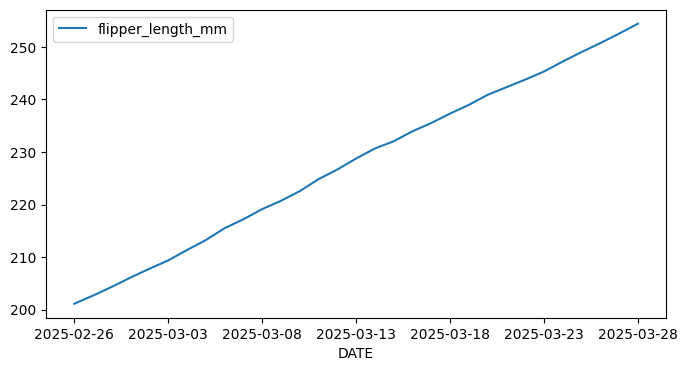

In [28]:
serve['flipper_length_mm'].plot(legend = True, figsize = (8, 4))

<Axes: xlabel='DATE'>

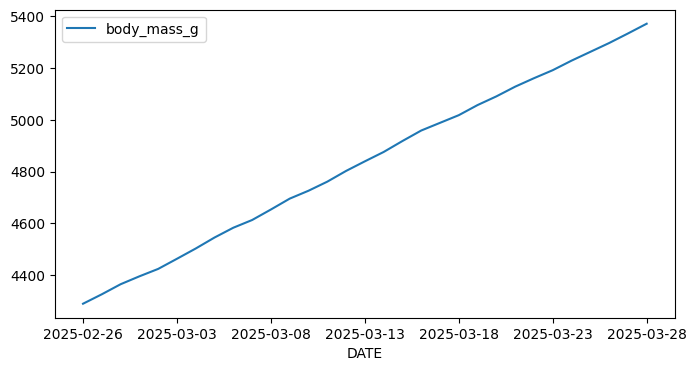

In [29]:
serve['body_mass_g'].plot(legend = True, figsize = (8, 4))

---
## Monitoring With Evaluations

It might seem like ongoing model evaluations are a great solution to model monitoring.  If the actual known values are available immediately then this could be possible to use for monitoring.  However, detecting a change in evaluation metrics means the model has realized a degradation.  It is a lagging signal.  To be more proactive we should monitor the inputs to the model, the features.  More on that in the next section.

First, look at the evaluation metrics for the most recent days data which has the cumulative change of the past 30 days introduced above.  In this case, the actual known values is known. This may not be possible in many real-world examples where the actual known values are:
- delayed by minutes, hours, days, or even longer
- not always known for all instances
- potentially in a different status that can change over a period of time before being confirmed as final

In reviewing the evaluation for the most recent instances here, the `precision` has dropped and the `log_loss` has increased drastically.  The confusion matrix shows Chinstrap penguins's are now being misclassified much more often than when the model was trained.  

The question becomes "How soon could this have been noticed?".

In [30]:
%%bigquery
SELECT *
FROM ML.EVALUATE (
    MODEL `statmike-mlops-349915.bqml_model_monitoring.classify_species_rf`,
    (
        SELECT *
        FROM `statmike-mlops-349915.bqml_model_monitoring.serving`
        WHERE DATE(instance_timestamp) >= CURRENT_DATE()
    )
)

Query is running:   0%|          |

Downloading:   0%|          |

,precision,recall,accuracy,f1_score,log_loss,roc_auc
0,0.956989,0.925926,0.936508,0.937796,0.486417,0.991305


In [31]:
%%bigquery
SELECT *
FROM ML.CONFUSION_MATRIX (
    MODEL `statmike-mlops-349915.bqml_model_monitoring.classify_species_rf`,
    (
        SELECT *
        FROM `statmike-mlops-349915.bqml_model_monitoring.serving`
        WHERE DATE(instance_timestamp) >= CURRENT_DATE()
    )
)

Query is running:   0%|          |

Downloading:   0%|          |

,expected_label,Adelie Penguin _Pygoscelis adeliae_,Chinstrap penguin _Pygoscelis antarctica_,Gentoo penguin _Pygoscelis papua_
0,Adelie Penguin (Pygoscelis adeliae),24,0,3
1,Chinstrap penguin (Pygoscelis antarctica),0,8,1
2,Gentoo penguin (Pygoscelis papua),0,0,27


### Evaluations: Over Time

In this case, we know the actual identification of the `species` and are measuring the same penguins daily.  Reviewing the evaluations daily could give a good sense of how the model is performing on a daily basis.

The result of the daily evaluations below shows that the log_loss starts to increase immediately and it takes more than a week for a noticable impact on precision/recall/accuracy/f1_score. 

What if the actual values where only known after a lag of days or weeks?  How quickly would evaluations be able to indicate the model's accuracy is possibly questionable?  The answer is a different approach - Model Monitoring.  This is covered in the section that follows.

In [32]:
%%bigquery evaluations
DECLARE counter INT64 DEFAULT 30;
DECLARE result STRUCT<precision FLOAT64, recall FLOAT64, accuracy FLOAT64, f1_score FLOAT64, log_loss FLOAT64, roc_auc FLOAT64, eval_date DATE>;
DECLARE results ARRAY<STRUCT<precision FLOAT64, recall FLOAT64, accuracy FLOAT64, f1_score FLOAT64, log_loss FLOAT64, roc_auc FLOAT64, eval_date DATE>> DEFAULT [];
LOOP
    IF counter < 0 THEN LEAVE;
    END IF;
    SET result = (
            SELECT AS STRUCT precision, recall, accuracy, f1_score, log_loss, roc_auc, DATE_SUB(CURRENT_DATE(), INTERVAL counter DAY) AS eval_date
            FROM ML.EVALUATE (
                MODEL `statmike-mlops-349915.bqml_model_monitoring.classify_species_rf`,
                (
                    SELECT *
                    FROM `statmike-mlops-349915.bqml_model_monitoring.serving`
                    WHERE DATE(instance_timestamp) = DATE_SUB(CURRENT_DATE(), INTERVAL counter DAY)
                )
            )
    );
    SET results = ARRAY_CONCAT(results,[result]);
    SET counter = counter - 1;
END LOOP;
SELECT * FROM UNNEST(results);

Query is running:   0%|          |

Downloading:   0%|          |

In [33]:
evaluations

,precision,recall,accuracy,f1_score,log_loss,roc_auc,eval_date
0,0.988095,0.962963,0.984127,0.974332,0.322304,0.997534,2025-02-26
1,0.988095,0.962963,0.984127,0.974332,0.323163,0.994410,2025-02-27
2,0.988095,0.962963,0.984127,0.974332,0.321347,0.993049,2025-02-28
3,0.988095,0.962963,0.984127,0.974332,0.325030,0.991669,2025-03-01
4,0.988095,0.962963,0.984127,0.974332,0.327240,0.991324,2025-03-02
5,0.988095,0.962963,0.984127,0.974332,0.327514,0.990979,2025-03-03
6,0.988095,0.962963,0.984127,0.974332,0.327168,0.989925,2025-03-04
7,0.988095,0.962963,0.984127,0.974332,0.329757,0.989925,2025-03-05
8,0.950617,0.950617,0.968254,0.950617,0.354675,0.985114,2025-03-06
9,0.950617,0.950617,0.968254,0.950617,0.359308,0.985114,2025-03-07


In [34]:
evaluations.set_index('eval_date', inplace = True)

<Axes: title={'center': 'Evaluation Metrics Over Last 30 days'}, xlabel='eval_date'>

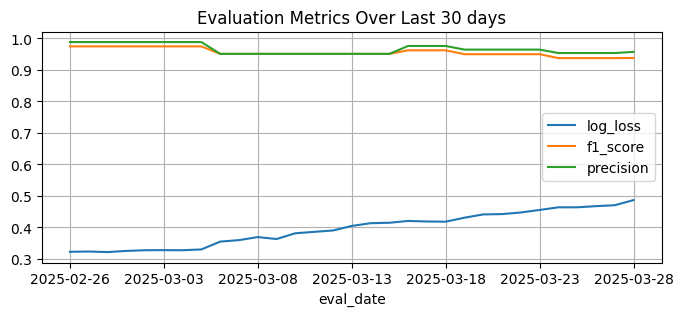

In [35]:
evaluations.plot(y = ['log_loss', 'f1_score', 'precision'], legend = True, title = 'Evaluation Metrics Over Last 30 days', figsize = (8, 3), grid = True)

---
## **Model Monitoring**

Reviewing model evaluations over time does show a pattern of deterioration in the example above.  But at what point is it actionable?  And what if each days evaluations are relying on actual values that took hours, days, weeks, or even months to be available?  

Model monitoring takes a different approach.  It goes back to the source of the model, each input feature.  These features form a distribution at the input to the model (the training data) and this can be used to compare to over time.  By setting thresholds on these comparisons to the original training data, alerts can be used to notify that a models accuracy *could be* in question.  This comparison to the training data is called **skew** detection.

Similarly, each days values could be compared to the previous days, or weeks values.  These comparisons are referred to as **drift** detection.  

Both of these types of comparisons can be done directly in BigQuery with two functions built for these tasks:
- [`ML.VALIDATE_DATA_SKEW`](https://cloud.google.com/bigquery/docs/reference/standard-sql/bigqueryml-syntax-validate-data-skew)
- [`ML.VALIDATE_DATA_DRIFT`](https://cloud.google.com/bigquery/docs/reference/standard-sql/bigqueryml-syntax-validate-data-drift)

### Monitoring Skew (Change from training) With `ML.VALIDATE_DATA_SKEW`

Compare today, or any data, to the training data by directly comparing to the the model created in BigQuery.

>**NOTE:** By adding the `enable_visualization_link` argument to the `ML.VALIDATE_DATA_SKEW` function it adds the Vertex AI Model Monitoring console link in the `visualization_link` column of the output.  Read more about [Monitoring visualization](https://cloud.google.com/bigquery/docs/model-monitoring-overview#monitoring_visualization) in the BigQuery ML [Model monitoring overview](https://cloud.google.com/bigquery/docs/model-monitoring-overview).

In [36]:
%%bigquery skew
SELECT *
FROM ML.VALIDATE_DATA_SKEW(
    # base
    MODEL `statmike-mlops-349915.bqml_model_monitoring.classify_species_rf`,
    (# compare
        SELECT *
        FROM `statmike-mlops-349915.bqml_model_monitoring.serving`
        WHERE DATE(instance_timestamp) >= CURRENT_DATE()
    )
    ,STRUCT(TRUE AS enable_visualization_link)
);

Query is running:   0%|          |

Downloading:   0%|          |

In [37]:
skew

,input,metric,threshold,value,is_anomaly,visualization_link
0,body_mass_g,JENSEN_SHANNON_DIVERGENCE,0.3,0.325832,True,https://console.cloud.google.com/vertex-ai/mod...
1,culmen_depth_mm,JENSEN_SHANNON_DIVERGENCE,0.3,0.026408,False,https://console.cloud.google.com/vertex-ai/mod...
2,culmen_length_mm,JENSEN_SHANNON_DIVERGENCE,0.3,0.041984,False,https://console.cloud.google.com/vertex-ai/mod...
3,flipper_length_mm,JENSEN_SHANNON_DIVERGENCE,0.3,0.862887,True,https://console.cloud.google.com/vertex-ai/mod...
4,island,L_INFTY,0.3,0.115780,False,https://console.cloud.google.com/vertex-ai/mod...
5,sex,L_INFTY,0.3,0.073147,False,https://console.cloud.google.com/vertex-ai/mod...


In [40]:
display(HTML(f'<a href="{skew.visualization_link[0]}" target="_blank" style="font-size: 18px;">Open Google Cloud Console in a new tab</a>'))

In [52]:
display(HTML('<div style="text-align: center;"><img src="./resources/tutorial_skew.gif" style="border: 2px solid black; width: auto; height: 600px;"></div>'))

### Monitoring Drift (Change Over Time) With `ML.VALIDATE_DATA_DRIFT`

Compare today to 5 days ago and set the a lower, more sensitive, threshold of `0.03` (default is `0.3`) for all features.


>**NOTE:** By adding the `MODEL` to the `ML.VALIDATE_DATA_DRIFT` function it adds the Vertex AI Model Monitoring console link in the `visualization_link` column of the output.  Read more about [Monitoring visualization](https://cloud.google.com/bigquery/docs/model-monitoring-overview#monitoring_visualization) in the BigQuery ML [Model monitoring overview](https://cloud.google.com/bigquery/docs/model-monitoring-overview).

In [42]:
%%bigquery drift
SELECT *
FROM ML.VALIDATE_DATA_DRIFT(
    (# base
        SELECT * EXCEPT(instance_timestamp, species)
        FROM `statmike-mlops-349915.bqml_model_monitoring.serving`
        WHERE DATE(instance_timestamp) = DATE_SUB(CURRENT_DATE(), INTERVAL 5 DAY)
    ),
    (# compare
        SELECT * EXCEPT(instance_timestamp, species)
        FROM `statmike-mlops-349915.bqml_model_monitoring.serving`
        WHERE DATE(instance_timestamp) = CURRENT_DATE() 
    ),
    STRUCT(
        0.03 AS categorical_default_threshold,
        0.03 AS numerical_default_threshold
    )
    , MODEL `statmike-mlops-349915.bqml_model_monitoring.classify_species_rf`
);

Query is running:   0%|          |

Downloading:   0%|          |

In [43]:
drift

,input,metric,threshold,value,is_anomaly,visualization_link
0,body_mass_g,JENSEN_SHANNON_DIVERGENCE,0.03,0.069689,True,https://console.cloud.google.com/vertex-ai/mod...
1,culmen_depth_mm,JENSEN_SHANNON_DIVERGENCE,0.03,0.000000,False,https://console.cloud.google.com/vertex-ai/mod...
2,culmen_length_mm,JENSEN_SHANNON_DIVERGENCE,0.03,0.000000,False,https://console.cloud.google.com/vertex-ai/mod...
3,flipper_length_mm,JENSEN_SHANNON_DIVERGENCE,0.03,0.111266,True,https://console.cloud.google.com/vertex-ai/mod...
4,island,L_INFTY,0.03,0.000000,False,https://console.cloud.google.com/vertex-ai/mod...
5,sex,L_INFTY,0.03,0.000000,False,https://console.cloud.google.com/vertex-ai/mod...


In [44]:
display(HTML(f'<a href="{drift.visualization_link[0]}" target="_blank" style="font-size: 18px;">Open Google Cloud Console in a new tab</a>'))

In [53]:
display(HTML('<div style="text-align: center;"><img src="./resources/tutorial_drift.gif" style="border: 2px solid black; width: auto; height: 600px;"></div>'))

### Monitoring Skew (Manually) - As Drift from Training Data

Since the `ML.VALIDATE_DATA_DRIFT` is comparing two tables, it could also be used for **skew** by comparing the training data to new data, like todays data:

In [49]:
%%bigquery skew_manual
SELECT *
FROM ML.VALIDATE_DATA_DRIFT(
    (# base
        SELECT *
        FROM `statmike-mlops-349915.bqml_model_monitoring.training_split`
        WHERE splits = 'TRAIN'
    ),
    (# compare
        SELECT * EXCEPT(instance_timestamp, species)
        FROM `statmike-mlops-349915.bqml_model_monitoring.serving`
        WHERE DATE(instance_timestamp) = CURRENT_DATE() 
    ),
    STRUCT()
    , MODEL `statmike-mlops-349915.bqml_model_monitoring.classify_species_rf`
);

Query is running:   0%|          |

Downloading:   0%|          |

In [50]:
skew_manual

,input,metric,threshold,value,is_anomaly,visualization_link
0,body_mass_g,JENSEN_SHANNON_DIVERGENCE,0.3,0.325832,True,https://console.cloud.google.com/vertex-ai/mod...
1,culmen_depth_mm,JENSEN_SHANNON_DIVERGENCE,0.3,0.026408,False,https://console.cloud.google.com/vertex-ai/mod...
2,culmen_length_mm,JENSEN_SHANNON_DIVERGENCE,0.3,0.041984,False,https://console.cloud.google.com/vertex-ai/mod...
3,flipper_length_mm,JENSEN_SHANNON_DIVERGENCE,0.3,0.862887,True,https://console.cloud.google.com/vertex-ai/mod...
4,island,L_INFTY,0.3,0.115780,False,https://console.cloud.google.com/vertex-ai/mod...
5,sex,L_INFTY,0.3,0.073147,False,https://console.cloud.google.com/vertex-ai/mod...


In [51]:
display(HTML(f'<a href="{skew_manual.visualization_link[0]}" target="_blank" style="font-size: 18px;">Open Google Cloud Console in a new tab</a>'))

In [54]:
display(HTML('<div style="text-align: center;"><img src="./resources/tutorial_skew_manual.gif" style="border: 2px solid black; width: auto; height: 600px;"></div>'))

---
### TensorFlow Data Validation (TFDV) In BigQuery

BigQuery offers two functions that bring the power of the TensorFlow's [TFX platform](https://www.tensorflow.org/tfx) with built-in [TensorFlow Data Validation (TFDV)](https://www.tensorflow.org/tfx/data_validation/get_started) module directly inside of BigQuery.
- [`ML.TFDV_DESCRIBE`](https://cloud.google.com/bigquery/docs/reference/standard-sql/bigqueryml-syntax-tfdv-describe) to generate descriptive statistics of any table
- [`ML.TFDV_VALIDATE`](https://cloud.google.com/bigquery/docs/reference/standard-sql/bigqueryml-syntax-tfdv-validate) to compare statistics of two tables

#### Generate Statistics with `ML.TFDV_DESCRIBE`

Generate statistics for any table, in this case the training data features or a timespan of serving data features.  This is like using the TensorFlow's [TFX platform](https://www.tensorflow.org/tfx) with built-in [TensorFlow Data Validation (TFDV)](https://www.tensorflow.org/tfx/data_validation/get_started) module's [`tfdv.generate_statistics_from_csv()`](https://www.tensorflow.org/tfx/data_validation/api_docs/python/tfdv/generate_statistics_from_csv) method.

The descriptions can be used in comparisons for skew or drift detection with the `ML.TFDV_VALIDATE` function, covered next, as well as in the visualization tool `tfdv.visualize_statistics` also covered below.

In [55]:
%%bigquery train_describe
SELECT *
FROM ML.TFDV_DESCRIBE(
    (
        SELECT * EXCEPT(splits, species)
        FROM `statmike-mlops-349915.bqml_model_monitoring.training_split`
        WHERE splits = 'TRAIN'
    )
)

Query is running:   0%|          |

Downloading:   0%|          |

In [56]:
train_describe = json.loads(train_describe['dataset_feature_statistics_list'].iloc[0])

In [57]:
train_describe['datasets'][0]['features'][0]

{'name': 'body_mass_g',
 'num_stats': {'common_stats': {'avg_num_values': 1,
   'max_num_values': 1,
   'min_num_values': 1,
   'num_missing': 2,
   'num_non_missing': 236,
   'num_values_histogram': {'buckets': [{'high_value': 1,
      'low_value': 1,
      'sample_count': 23.6},
     {'high_value': 1, 'low_value': 1, 'sample_count': 23.6},
     {'high_value': 1, 'low_value': 1, 'sample_count': 23.6},
     {'high_value': 1, 'low_value': 1, 'sample_count': 23.6},
     {'high_value': 1, 'low_value': 1, 'sample_count': 23.6},
     {'high_value': 1, 'low_value': 1, 'sample_count': 23.6},
     {'high_value': 1, 'low_value': 1, 'sample_count': 23.6},
     {'high_value': 1, 'low_value': 1, 'sample_count': 23.6},
     {'high_value': 1, 'low_value': 1, 'sample_count': 23.6},
     {'high_value': 1, 'low_value': 1, 'sample_count': 23.6}],
    'type': 'QUANTILES'},
   'tot_num_values': 236},
  'histograms': [{'buckets': [{'high_value': 3250,
      'low_value': 2700,
      'sample_count': 23.6},
 

In [58]:
%%bigquery today_describe
SELECT *
FROM ML.TFDV_DESCRIBE(
    (
        SELECT * EXCEPT(instance_timestamp, species)
        FROM `statmike-mlops-349915.bqml_model_monitoring.serving`
        WHERE DATE(instance_timestamp) = CURRENT_DATE()
    )
)

Query is running:   0%|          |

Downloading:   0%|          |

In [59]:
today_describe = json.loads(today_describe['dataset_feature_statistics_list'].iloc[0])

In [60]:
#today_describe['datasets'][0]['features'][0]

#### Visualize Statistics with `tfdv.visualize_statistics`

Use the [`tfdv.visualize_statistics`](https://www.tensorflow.org/tfx/data_validation/api_docs/python/tfdv/visualize_statistics) tool to visualize the generated descriptions and directly compare them.  This presents visuals using [Facets Overview](https://pair-code.github.io/facets/).

In [61]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow_data_validation as tfdv
import tensorflow_metadata as tfmd
from google.protobuf import json_format

In [62]:
tfdv.visualize_statistics(
    lhs_statistics = json_format.ParseDict(train_describe, tfmd.proto.statistics_pb2.DatasetFeatureStatisticsList()),
    rhs_statistics = json_format.ParseDict(today_describe, tfmd.proto.statistics_pb2.DatasetFeatureStatisticsList()),
    lhs_name = 'Training Data Stats',
    rhs_name = 'Serving Data Stats - For Today'
)

In [63]:
display(HTML('<div style="text-align: center;"><img src="./resources/tutorial_tfdv_visualize.gif" style="border: 2px solid black; width: auto; height: 400px;"></div>'))

#### Compare And Detect Anomalies with `ML.TFDV_VALIDATE`

Compare the distribution of any table to a base table and compute distance statistics to detect anomalies.  This is like using the TensorFlow's [TFX platform](https://www.tensorflow.org/tfx) with built-in [TensorFlow Data Validation (TFDV)](https://www.tensorflow.org/tfx/data_validation/get_started) module's [validate_statistics api](https://www.tensorflow.org/tfx/data_validation/api_docs/python/tfdv/validate_statistics).

These comparison can be made to training data for **skew** detection or previous serving data for **drift** detection.

In [64]:
%%bigquery validate
WITH
    TRAIN AS (
        SELECT * EXCEPT(splits, species)
        FROM `statmike-mlops-349915.bqml_model_monitoring.training_split`
        WHERE splits = 'TRAIN'
    ),
    SERVE AS (
        SELECT * EXCEPT(instance_timestamp, species)
        FROM `statmike-mlops-349915.bqml_model_monitoring.serving`
        WHERE DATE(instance_timestamp) = CURRENT_DATE()
    )
SELECT ML.TFDV_VALIDATE(
    (SELECT * FROM ML.TFDV_DESCRIBE(TABLE TRAIN)),
    (SELECT * FROM ML.TFDV_DESCRIBE(TABLE SERVE)),
    'SKEW'
) as validate

Query is running:   0%|          |

Downloading:   0%|          |

In [65]:
validate = json.loads(validate['validate'].iloc[0])

In [66]:
#validate['anomaly_info']

#### Display Anomalies with `tfdv.display_anomalies`

Use the [`tfdv.display_anomalies`](https://www.tensorflow.org/tfx/data_validation/api_docs/python/tfdv/display_anomalies) tool to display a table of anomaly detections with descriptions.

In [67]:
if 'generate_legacy_feature_spec' in validate['baseline'].keys():
    del validate['baseline']['generate_legacy_feature_spec']

In [68]:
tfdv.display_anomalies(
    anomalies = json_format.ParseDict(validate, tfmd.proto.anomalies_pb2.Anomalies())
)

,Anomaly short description,Anomaly long description
Feature name,,
'body_mass_g',High approximate Jensen-Shannon divergence between training and serving,"The approximate Jensen-Shannon divergence between training and serving is 0.325832 (up to six significant digits), above the threshold 0.3."
'flipper_length_mm',High approximate Jensen-Shannon divergence between training and serving,"The approximate Jensen-Shannon divergence between training and serving is 0.862887 (up to six significant digits), above the threshold 0.3."


---
## Understanding Monitoring Thresholds

The `ML.VALIDATE_DATA_DRIFT`, `ML.VALIDATE_DATA_SKEW`, and `ML.TFDV_VALIDATE` functions use distance scores to quantify the change in the statistical distribution of features.  The methods of calculating the distance scores are:
- [L-infinity distance](https://en.wikipedia.org/wiki/Chebyshev_distance) for categorical features
- [Jensen-Shannon divergence](https://en.wikipedia.org/wiki/Jensen%E2%80%93Shannon_divergence) for numeric features.  Can also be use for categorical features.

These methods are the same ones used by [TensorFlow Data Validation](https://www.tensorflow.org/tfx/guide/tfdv#training-serving_skew_detection) which is also used in [Vertex AI Model Monitoring](https://cloud.google.com/vertex-ai/docs/model-monitoring/overview#calculating-skew-and-drift).

This section aims to provide intuition on how these two metrics work.  In the data used for this workflow the feature `island` has three possible values: `Biscoe`, `Dream`, and `Torgersen`.  The proportion of data in each of these categories forms a distribution.  This will be used to visually show how both methods of calculating distance scores work.

In [69]:
import pandas as pd
import numpy as np

### Retrieve Distributions: Training & Serving

Use the `ML.TFDV_DESCRIBE` function to get the statistics for the distribution of the `island` feature at both training and for serving.

In [70]:
%%bigquery island_train
SELECT *
FROM ML.TFDV_DESCRIBE(
    (
        SELECT island
        FROM `statmike-mlops-349915.bqml_model_monitoring.training_split`
        WHERE splits = 'TRAIN'
    )
)

Query is running:   0%|          |

Downloading:   0%|          |

In [71]:
%%bigquery island_serve
SELECT *
FROM ML.TFDV_DESCRIBE(
    (
        SELECT island
        FROM `statmike-mlops-349915.bqml_model_monitoring.serving`
    )
)

Query is running:   0%|          |

Downloading:   0%|          |

In [72]:
island_train = json.loads(island_train['dataset_feature_statistics_list'].iloc[0])
island_serve = json.loads(island_serve['dataset_feature_statistics_list'].iloc[0])

In [73]:
island_train['datasets'][0]['features'][0]['string_stats']

{'avg_length': 6.092437,
 'common_stats': {'avg_num_values': 1,
  'max_num_values': 1,
  'min_num_values': 1,
  'num_non_missing': 238,
  'num_values_histogram': {'buckets': [{'high_value': 1,
     'low_value': 1,
     'sample_count': 23.8},
    {'high_value': 1, 'low_value': 1, 'sample_count': 23.8},
    {'high_value': 1, 'low_value': 1, 'sample_count': 23.8},
    {'high_value': 1, 'low_value': 1, 'sample_count': 23.8},
    {'high_value': 1, 'low_value': 1, 'sample_count': 23.8},
    {'high_value': 1, 'low_value': 1, 'sample_count': 23.8},
    {'high_value': 1, 'low_value': 1, 'sample_count': 23.8},
    {'high_value': 1, 'low_value': 1, 'sample_count': 23.8},
    {'high_value': 1, 'low_value': 1, 'sample_count': 23.8},
    {'high_value': 1, 'low_value': 1, 'sample_count': 23.8}],
   'type': 'QUANTILES'},
  'tot_num_values': 238},
 'rank_histogram': {'buckets': [{'label': 'Biscoe', 'sample_count': 116},
   {'high_rank': 1, 'label': 'Dream', 'low_rank': 1, 'sample_count': 86},
   {'high

In [74]:
island_train_stats = island_train['datasets'][0]['features'][0]['string_stats']['rank_histogram']['buckets']
island_train_stats

[{'label': 'Biscoe', 'sample_count': 116},
 {'high_rank': 1, 'label': 'Dream', 'low_rank': 1, 'sample_count': 86},
 {'high_rank': 2, 'label': 'Torgersen', 'low_rank': 2, 'sample_count': 36}]

In [75]:
island_serve_stats = island_serve['datasets'][0]['features'][0]['string_stats']['rank_histogram']['buckets']
island_serve_stats

[{'label': 'Biscoe', 'sample_count': 1178},
 {'high_rank': 1, 'label': 'Dream', 'low_rank': 1, 'sample_count': 558},
 {'high_rank': 2, 'label': 'Torgersen', 'low_rank': 2, 'sample_count': 217}]

### Combine Distributions In DataFrame

In [76]:
index = [i['label'] for i in island_train_stats]
train = [i['sample_count'] for i in island_train_stats]
serve = [island_serve_stats[index.index(k)]['sample_count'] for k in [i['label'] for i in island_serve_stats]]
stats = pd.DataFrame(
    {
        'train_n': train,
        'serve_n': serve,
        'train_pct': [x/sum(train) for x in train],
        'serve_pct': [x/sum(serve) for x in serve]
    },
    index = index
)
stats

,train_n,serve_n,train_pct,serve_pct
Biscoe,116,1178,0.487395,0.603175
Dream,86,558,0.361345,0.285714
Torgersen,36,217,0.151261,0.111111


### Visualize Distributions

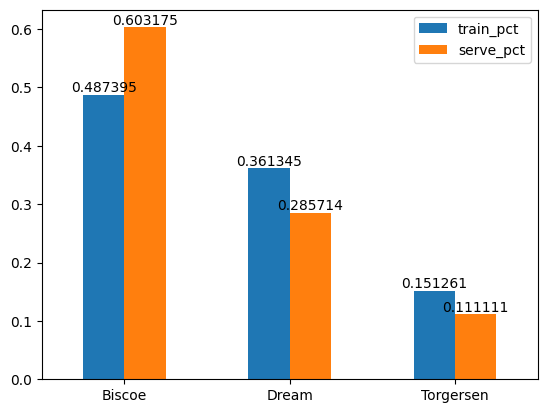

In [77]:
ax = stats[['train_pct', 'serve_pct']].plot.bar(rot=0)
for container in ax.containers:
    ax.bar_label(container)

### L-Infinity Distance

In [78]:
stats['abs_change_pct'] = abs(stats['train_pct'] - stats['serve_pct'])
stats

,train_n,serve_n,train_pct,serve_pct,abs_change_pct
Biscoe,116,1178,0.487395,0.603175,0.115780
Dream,86,558,0.361345,0.285714,0.075630
Torgersen,36,217,0.151261,0.111111,0.040149


[Text(0, 0, '0.11578'), Text(0, 0, '0.0756303'), Text(0, 0, '0.0401494')]

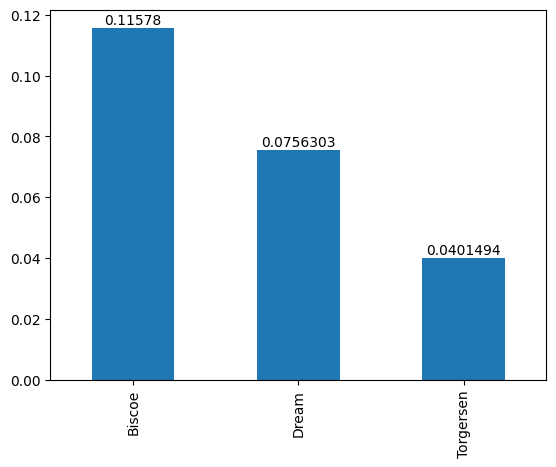

In [79]:
ax = stats['abs_change_pct'].plot.bar()
ax.bar_label(ax.containers[0])

In [80]:
print(f"The max change in percentage(L-Infinity Distance) is {max(stats['abs_change_pct'])}")

The max change in percentage(L-Infinity Distance) is 0.11577964519140987


### Jensen-Shannon Divergence

In [81]:
stats['mix'] = (stats['train_pct'] + stats['serve_pct']) / 2
stats['train_kl'] = stats['train_pct'] * np.log2(stats['train_pct'] / stats['mix'])
stats['serve_kl'] = stats['serve_pct'] * np.log2(stats['serve_pct'] / stats['mix'])
stats['JSD'] = (stats['train_kl'] + stats['serve_kl']) / 2
stats

,train_n,serve_n,train_pct,serve_pct,abs_change_pct,mix,train_kl,serve_kl,JSD
Biscoe,116,1178,0.487395,0.603175,0.115780,0.545285,-0.078918,0.087802,0.004442
Dream,86,558,0.361345,0.285714,0.075630,0.323529,0.057627,-0.051235,0.003196
Torgersen,36,217,0.151261,0.111111,0.040149,0.131186,0.031072,-0.026623,0.002225


In [82]:
print(f"The total for the Jansen-Shannon Divergence is {sum(stats['JSD'])}")

The total for the Jansen-Shannon Divergence is 0.009861927954957363


### Verify Calculations with `ML.VALIDATE_DATA_DRIFT`

In [83]:
%%bigquery
SELECT *
FROM ML.VALIDATE_DATA_DRIFT(
    (
        SELECT island
        FROM `statmike-mlops-349915.bqml_model_monitoring.training_split`
        WHERE splits = 'TRAIN'
    ),
    (
        SELECT island
        FROM `statmike-mlops-349915.bqml_model_monitoring.serving`
    ),
    STRUCT('L_INFTY' AS categorical_metric_type)
    #, MODEL `statmike-mlops-349915.bqml_model_monitoring.classify_species_rf`
)

Query is running:   0%|          |

Downloading:   0%|          |

,input,metric,threshold,value,is_anomaly
0,island,L_INFTY,0.3,0.11578,False


In [84]:
print(f"The max change in percentage(L-Infinity Distance) is {max(stats['abs_change_pct'])}")

The max change in percentage(L-Infinity Distance) is 0.11577964519140987


In [85]:
%%bigquery
SELECT *
FROM ML.VALIDATE_DATA_DRIFT(
    (
        SELECT island
        FROM `statmike-mlops-349915.bqml_model_monitoring.training_split`
        WHERE splits = 'TRAIN'
    ),
    (
        SELECT island
        FROM `statmike-mlops-349915.bqml_model_monitoring.serving`
    ),
    STRUCT('JENSEN_SHANNON_DIVERGENCE' AS categorical_metric_type)
    #, MODEL `statmike-mlops-349915.bqml_model_monitoring.classify_species_rf`
)

Query is running:   0%|          |

Downloading:   0%|          |

,input,metric,threshold,value,is_anomaly
0,island,JENSEN_SHANNON_DIVERGENCE,0.3,0.009862,False


In [86]:
print(f"The total for the Jansen-Shannon Divergence is {sum(stats['JSD'])}")

The total for the Jansen-Shannon Divergence is 0.009861927954957363


---
## More Applications For Model Monitoring

---
### Monitoring Transformed Features

The [`CREATE MODEL`](https://cloud.google.com/bigquery/docs/reference/standard-sql/bigqueryml-syntax-create) statement included a [`TRANSFORM`](https://cloud.google.com/bigquery/docs/reference/standard-sql/bigqueryml-syntax-create#transform).  This is available to be called directly for input data with the [`ML.TRANSFORM`](https://cloud.google.com/bigquery/docs/reference/standard-sql/bigqueryml-syntax-transform) function.  This can be useful for considering monitoring the transformed features.

#### Transformations With `ML.TRANSFORM`

In [70]:
%%bigquery
SELECT *
FROM ML.TRANSFORM(
    MODEL `statmike-mlops-349915.bqml_model_monitoring.classify_species_rf`,
    (
        SELECT *
        FROM `statmike-mlops-349915.bqml_model_monitoring.serving`
        LIMIT 5
    )
)

Query is running:   0%|          |

Downloading:   0%|          |

,body_mass_g,culmen_length_mm,culmen_depth_mm,flipper_length_mm,sex,island,species,instance_timestamp
0,0.532233,0.094817,-1.459731,bin_3,FEMALE,Biscoe,Gentoo penguin (Pygoscelis papua),2025-02-19 00:00:00+00:00
1,-0.386502,-1.627776,-0.623838,bin_2,FEMALE,Torgersen,Adelie Penguin (Pygoscelis adeliae),2025-02-19 00:00:00+00:00
2,-0.332031,-2.201973,-0.832811,bin_3,FEMALE,Dream,Adelie Penguin (Pygoscelis adeliae),2025-02-19 00:00:00+00:00
3,-0.084418,-0.979488,0.995706,bin_3,FEMALE,Torgersen,Adelie Penguin (Pygoscelis adeliae),2025-02-19 00:00:00+00:00
4,-0.503243,-1.405506,0.003082,bin_3,FEMALE,Biscoe,Adelie Penguin (Pygoscelis adeliae),2025-02-19 00:00:00+00:00


#### Monitoring Skew (Manually) - As Drift from Training Data With `ML.VALIDATE_DATA_DRIFT`

Compare today, or any data, to the training data by directly comparing to the the model created in BigQuery.

In [71]:
%%bigquery
SELECT *
FROM ML.VALIDATE_DATA_DRIFT(
    (
        SELECT *
        FROM ML.TRANSFORM(
            MODEL `statmike-mlops-349915.bqml_model_monitoring.classify_species_rf`,
            (
                SELECT *
                FROM `statmike-mlops-349915.bqml_model_monitoring.training_split`
                WHERE splits = 'TRAIN'
            )
        )
    ),
    (
        SELECT *
        FROM ML.TRANSFORM(
            MODEL `statmike-mlops-349915.bqml_model_monitoring.classify_species_rf`,
            (
                SELECT *
                FROM `statmike-mlops-349915.bqml_model_monitoring.serving`
                WHERE DATE(instance_timestamp) >= CURRENT_DATE()
            )
        )
    )
    #, MODEL `statmike-mlops-349915.bqml_model_monitoring.classify_species_rf`
);

Query is running:   0%|          |

Downloading:   0%|          |

,input,metric,threshold,value,is_anomaly
0,body_mass_g,JENSEN_SHANNON_DIVERGENCE,0.3,0.370903,True
1,culmen_depth_mm,JENSEN_SHANNON_DIVERGENCE,0.3,0.029107,False
2,culmen_length_mm,JENSEN_SHANNON_DIVERGENCE,0.3,0.058572,False
3,flipper_length_mm,L_INFTY,0.3,0.652542,True
4,island,L_INFTY,0.3,0.063666,False
5,sex,L_INFTY,0.3,0.059037,False
6,species,L_INFTY,0.3,0.073707,False


#### Monitoring Drift (Change Over Time) With `ML.VALIDATE_DATA_DRIFT`

Compare today to 5 days ago and set the a lower, more sensitive, threshold of `0.03` (default is `0.3`) for all features.

In [72]:
%%bigquery
SELECT *
FROM ML.VALIDATE_DATA_DRIFT(
    (
        SELECT *
        FROM ML.TRANSFORM(
            MODEL `statmike-mlops-349915.bqml_model_monitoring.classify_species_rf`,
            (
                SELECT *
                FROM `statmike-mlops-349915.bqml_model_monitoring.serving`
                WHERE DATE(instance_timestamp) = DATE_SUB(CURRENT_DATE(), INTERVAL 5 DAY)
            )
        )
    ),
    (
        SELECT *
        FROM ML.TRANSFORM(
            MODEL `statmike-mlops-349915.bqml_model_monitoring.classify_species_rf`,
            (
                SELECT *
                FROM `statmike-mlops-349915.bqml_model_monitoring.serving`
                WHERE DATE(instance_timestamp) >= CURRENT_DATE()
            )
        )
    ),
    STRUCT(
        0.03 AS categorical_default_threshold,
        0.03 AS numerical_default_threshold
    )
    #, MODEL `statmike-mlops-349915.bqml_model_monitoring.classify_species_rf`
)

Query is running:   0%|          |

Downloading:   0%|          |

,input,metric,threshold,value,is_anomaly
0,body_mass_g,JENSEN_SHANNON_DIVERGENCE,0.03,0.047936,True
1,culmen_depth_mm,JENSEN_SHANNON_DIVERGENCE,0.03,0.000000,False
2,culmen_length_mm,JENSEN_SHANNON_DIVERGENCE,0.03,0.000000,False
3,flipper_length_mm,L_INFTY,0.03,0.000000,False
4,instance_timestamp,L_INFTY,0.03,1.000000,True
5,island,L_INFTY,0.03,0.000000,False
6,sex,L_INFTY,0.03,0.000000,False
7,species,L_INFTY,0.03,0.000000,False


---
### Monitoring Feature Attributions

BigQuery ML models, like the deep neural network classifier (`model_type = 'DNN_CLASSIFIER'`) used above, can also serve explanations using the BigQuery function [`ML.EXPLAIN_PREDICT`](https://cloud.google.com/bigquery/docs/reference/standard-sql/bigqueryml-syntax-explain-predict).  This function returns feature attributions for each feature used in the model to explain how much contribution was made to the final prediction for a given instance.

**Feature Attributions**

The feature attributions from `ML.EXPLAIN_PREDICT` are [local explanations](https://cloud.google.com/bigquery/docs/xai-overview#local_versus_global_explainability), specific to the instance being predicted.  The attribution values are given for each feature and they add up to the `prediction_value`. In this case the model is a classifier and the `prediction_value` is the logit value (log-odds) of the predicted class.  

#### Serving Feature Attributions

As an example, the following cell gets the feature attributions for a single penguin with for the latest values of the features:

In [73]:
%%bigquery
WITH
    EXPLAIN AS (
        SELECT * EXCEPT(body_mass_g, sex, island, flipper_length_mm, culmen_depth_mm, culmen_length_mm)
        FROM ML.EXPLAIN_PREDICT(
            MODEL `statmike-mlops-349915.bqml_model_monitoring.classify_species_rf`,
            (
                SELECT * EXCEPT(instance_timestamp, species)
                FROM `statmike-mlops-349915.bqml_model_monitoring.serving`
                WHERE DATE(instance_timestamp) = CURRENT_DATE()
                LIMIT 1
            ), 
            STRUCT(10 AS top_k_features)
        )
    ),
    ATTRIBUTIONS AS (
        SELECT * EXCEPT(top_feature_attributions),
        FROM EXPLAIN
        JOIN UNNEST(top_feature_attributions)
    )
SELECT * 
FROM ATTRIBUTIONS

Query is running:   0%|          |

Downloading:   0%|          |

,predicted_species,probability,baseline_prediction_value,prediction_value,approximation_error,feature,attribution
0,Gentoo penguin (Pygoscelis papua),0.813519,0.550766,1.949614,0.0,culmen_depth_mm,0.575787
1,Gentoo penguin (Pygoscelis papua),0.813519,0.550766,1.949614,0.0,flipper_length_mm,0.539715
2,Gentoo penguin (Pygoscelis papua),0.813519,0.550766,1.949614,0.0,body_mass_g,0.232519
3,Gentoo penguin (Pygoscelis papua),0.813519,0.550766,1.949614,0.0,island,0.028777
4,Gentoo penguin (Pygoscelis papua),0.813519,0.550766,1.949614,0.0,culmen_length_mm,0.012357
5,Gentoo penguin (Pygoscelis papua),0.813519,0.550766,1.949614,0.0,sex,0.009692


#### Reviewing Feature Attributions

Get attributions for all penguins:

In [74]:
%%bigquery explain
WITH
    EXPLAIN AS (
        SELECT * EXCEPT(body_mass_g, sex, island, flipper_length_mm, culmen_depth_mm, culmen_length_mm)
        FROM ML.EXPLAIN_PREDICT(
            MODEL `statmike-mlops-349915.bqml_model_monitoring.classify_species_rf`,
            (
                SELECT * EXCEPT(instance_timestamp, species)
                FROM `statmike-mlops-349915.bqml_model_monitoring.serving`
                WHERE DATE(instance_timestamp) = CURRENT_DATE()
            ), 
            STRUCT(10 AS top_k_features)
        )
    ),
    ATTRIBUTIONS AS (
        SELECT * EXCEPT(top_feature_attributions),
        FROM EXPLAIN
        JOIN UNNEST(top_feature_attributions)
    ),
    PIVOT_ATTRIBUTION AS (
        SELECT body_mass_g, sex, island, flipper_length_mm, culmen_depth_mm, culmen_length_mm
        FROM ATTRIBUTIONS PIVOT(MAX(attribution) FOR feature IN ('body_mass_g', 'sex', 'island', 'flipper_length_mm', 'culmen_depth_mm', 'culmen_length_mm'))
    )
SELECT *
FROM PIVOT_ATTRIBUTION

Query is running:   0%|          |

Downloading:   0%|          |

In [75]:
explain.head()

,body_mass_g,sex,island,flipper_length_mm,culmen_depth_mm,culmen_length_mm
0,0.232519,0.009692,0.028777,0.539715,0.575787,0.012357
1,0.068469,0.009692,0.026669,0.534876,0.750988,0.008155
2,0.230967,0.009692,0.028777,0.538591,0.578406,0.012415
3,0.224714,-0.004471,0.027133,0.564485,0.575787,0.011199
4,0.224714,-0.004471,0.027133,0.564485,0.575787,0.011199


#### Monitor Feature Attributions For Drift with `ML.VALIDATE_DATA_DRIFT`

Compare yesterday to 25 days ago:

In [76]:
%%bigquery
WITH
    EXPLAIN_BASE AS (
        SELECT * EXCEPT(body_mass_g, sex, island, flipper_length_mm, culmen_depth_mm, culmen_length_mm)
        FROM ML.EXPLAIN_PREDICT(
            MODEL `statmike-mlops-349915.bqml_model_monitoring.classify_species_rf`,
            (
                SELECT * EXCEPT(instance_timestamp, species)
                FROM `statmike-mlops-349915.bqml_model_monitoring.serving`
                WHERE DATE(instance_timestamp) = DATE_SUB(CURRENT_DATE(), INTERVAL 25 DAY)
            ), 
            STRUCT(10 AS top_k_features)
        )
    ),
    ATTRIBUTIONS_BASE AS (
        SELECT * EXCEPT(top_feature_attributions),
        FROM EXPLAIN_BASE
        JOIN UNNEST(top_feature_attributions)
    ),
    PIVOT_ATTRIBUTION_BASE AS (
        SELECT body_mass_g, sex, island, flipper_length_mm, culmen_depth_mm, culmen_length_mm
        FROM ATTRIBUTIONS_BASE PIVOT(MAX(attribution) FOR feature IN ('body_mass_g', 'sex', 'island', 'flipper_length_mm', 'culmen_depth_mm', 'culmen_length_mm'))
    ),
    EXPLAIN_COMP AS (
        SELECT * EXCEPT(body_mass_g, sex, island, flipper_length_mm, culmen_depth_mm, culmen_length_mm)
        FROM ML.EXPLAIN_PREDICT(
            MODEL `statmike-mlops-349915.bqml_model_monitoring.classify_species_rf`,
            (
                SELECT * EXCEPT(instance_timestamp, species)
                FROM `statmike-mlops-349915.bqml_model_monitoring.serving`
                WHERE DATE(instance_timestamp) = DATE_SUB(CURRENT_DATE(), INTERVAL 1 DAY)
            ), 
            STRUCT(10 AS top_k_features)
        )
    ),
    ATTRIBUTIONS_COMP AS (
        SELECT * EXCEPT(top_feature_attributions),
        FROM EXPLAIN_COMP
        JOIN UNNEST(top_feature_attributions)
    ),
    PIVOT_ATTRIBUTION_COMP AS (
        SELECT body_mass_g, sex, island, flipper_length_mm, culmen_depth_mm, culmen_length_mm
        FROM ATTRIBUTIONS_COMP PIVOT(MAX(attribution) FOR feature IN ('body_mass_g', 'sex', 'island', 'flipper_length_mm', 'culmen_depth_mm', 'culmen_length_mm'))
    )
SELECT *
FROM ML.VALIDATE_DATA_DRIFT(
    TABLE PIVOT_ATTRIBUTION_BASE,
    TABLE PIVOT_ATTRIBUTION_COMP
    #, MODEL `statmike-mlops-349915.bqml_model_monitoring.classify_species_rf`
);

Query is running:   0%|          |

Downloading:   0%|          |

,input,metric,threshold,value,is_anomaly
0,body_mass_g,JENSEN_SHANNON_DIVERGENCE,0.3,0.268127,False
1,culmen_depth_mm,JENSEN_SHANNON_DIVERGENCE,0.3,0.303297,True
2,culmen_length_mm,JENSEN_SHANNON_DIVERGENCE,0.3,0.374839,True
3,flipper_length_mm,JENSEN_SHANNON_DIVERGENCE,0.3,0.541789,True
4,island,JENSEN_SHANNON_DIVERGENCE,0.3,0.375135,True
5,sex,JENSEN_SHANNON_DIVERGENCE,0.3,0.305167,True


---
## Model Monitoring For Online Inference With Vertex AI

The model trained above was trained using BigQuery ML's [`CREATE MODEL` statement](https://cloud.google.com/bigquery/docs/reference/standard-sql/bigqueryml-syntax-create) along with the training option `MODEL_REGISTRY = "vertex_ai"` which automatically registers the model in the [Vertex AI Model Registry](https://cloud.google.com/vertex-ai/docs/model-registry/introduction).  This means the BigQuery ML models can be managed directly in Vertex AI - [more information](https://cloud.google.com/bigquery/docs/managing-models-vertex).

Models in the Vertex AI Model Registry can be used to [serve batch or online predictions](https://cloud.google.com/vertex-ai/docs/predictions/get-predictions).  In this section the [Vertex AI Python SDK](https://cloud.google.com/vertex-ai/docs/start/use-vertex-ai-python-sdk) is used to [deploy the model](https://cloud.google.com/vertex-ai/docs/general/deployment) created in this workflow and [get online predictions](https://cloud.google.com/vertex-ai/docs/predictions/get-online-predictions).

The deployment of the model will include an extra setting to [setup logging of prediction request and responses to BigQuery](https://cloud.google.com/vertex-ai/docs/predictions/online-prediction-logging#enabling-and-disabling).  By logging the request and responses to BigQuery we can easily use the model monitoring functions covered in this tutorial.

### Setup Client

In [77]:
from google.cloud import aiplatform
aiplatform.init(project = 'statmike-mlops-349915', location = 'us-central1')

### Get Model From Vertex AI Model Registry

In [78]:
model = aiplatform.Model(model_name = 'classify_species_rf')
model.versioned_resource_name

'projects/1026793852137/locations/us-central1/models/classify_species_rf@63'

### Deploy Model To Endpoint

In [79]:
endpoint = model.deploy()

Creating Endpoint
Create Endpoint backing LRO: projects/1026793852137/locations/us-central1/endpoints/5319952926133714944/operations/8706579684646715392
Endpoint created. Resource name: projects/1026793852137/locations/us-central1/endpoints/5319952926133714944
To use this Endpoint in another session:
endpoint = aiplatform.Endpoint('projects/1026793852137/locations/us-central1/endpoints/5319952926133714944')
Deploying model to Endpoint : projects/1026793852137/locations/us-central1/endpoints/5319952926133714944
Using default machine_type: n1-standard-2
Deploy Endpoint model backing LRO: projects/1026793852137/locations/us-central1/endpoints/5319952926133714944/operations/8346291714457075712
Endpoint model deployed. Resource name: projects/1026793852137/locations/us-central1/endpoints/5319952926133714944


In [80]:
endpoint.resource_name

'projects/1026793852137/locations/us-central1/endpoints/5319952926133714944'

### Get Data For Predictions

Get a sample of data from the serving table to use as online prediction requests.

In [81]:
%%bigquery online
SELECT * EXCEPT(species, instance_timestamp)
FROM statmike-mlops-349915.bqml_model_monitoring.serving
WHERE RAND() < 0.1

Query is running:   0%|          |

Downloading:   0%|          |

In [82]:
import numpy as np
online = online.dropna()
online['sex'].replace(np.nan, '', inplace=True)
online = online.to_dict(orient = 'records')
online[0]

{'island': 'Biscoe',
 'culmen_length_mm': 44.9,
 'culmen_depth_mm': 13.3,
 'sex': 'FEMALE',
 'flipper_length_mm': 218.02685785145871,
 'body_mass_g': 5176.888182285546}

### Get Predictions

In [83]:
endpoint.predict(instances = online[0:1])

Prediction(predictions=[{'species_values': ['Gentoo penguin (Pygoscelis papua)', 'Chinstrap penguin (Pygoscelis antarctica)', 'Adelie Penguin (Pygoscelis adeliae)'], 'predicted_species': 'Gentoo penguin (Pygoscelis papua)', 'species_probs': [0.8135186433792114, 0.09340284019708633, 0.09307850152254105]}], deployed_model_id='4696441872254500864', metadata=None, model_version_id='63', model_resource_name='projects/1026793852137/locations/us-central1/models/classify_species_rf', explanations=None)

### Enable Prediction request-response logging To BigQuery

The endpoint can be enabled for logging both the request and response for predictions.  These logs are directed to a BigQuery table.  This is enable throught the `gcloud ai endpoints update` command - [reference](https://cloud.google.com/sdk/gcloud/reference/ai/endpoints/update).

In [84]:
endpoint.name

'5319952926133714944'

In [85]:
!gcloud ai endpoints update $endpoint.name \
--region=us-central1 \
--request-response-logging-table=bq://statmike-mlops-349915.bqml_model_monitoring.serving_online

Using endpoint [https://us-central1-aiplatform.googleapis.com/]
Updated Vertex AI endpoint [projects/1026793852137/locations/us-central1/endpoints/5319952926133714944].


### Send Prediction Requests To Endpoint

These will get logged to the BigQuery table specified above.

In [86]:
for instance in online:
    prediction = endpoint.predict(instances = [instance])

In [87]:
%%bigquery
SELECT *
FROM `statmike-mlops-349915.bqml_model_monitoring.serving_online`
LIMIT 5

Query is running:   0%|          |

Downloading:   0%|          |

,endpoint,deployed_model_id,logging_time,request_id,request_payload,response_payload
0,projects/1026793852137/locations/us-central1/endpoints/8376174138397556736,679865422849245184,2024-04-18 12:18:11.485985+00:00,6467905174125477417.000000000,"[{""sex"":""FEMALE"",""flipper_length_mm"":252.61741067441787,""body_mass_g"":5327.8972889361776,""culmen_length_mm"":45.8,""culmen_depth_mm"":14.2,""island"":""Biscoe""}]","[{""predicted_species"":""Gentoo penguin (Pygoscelis papua)"",""species_probs"":[0.81451046466827393,0.092201024293899536,0.093288503587245941],""species_values"":[""Gentoo penguin (Pygoscelis papua)"",""Chinstrap penguin (Pygoscelis antarctica)"",""Adelie Penguin (Pygoscelis adeliae)""]}]"
1,projects/1026793852137/locations/us-central1/endpoints/8376174138397556736,679865422849245184,2024-04-18 12:18:11.866995+00:00,1325655541157377859.000000000,"[{""culmen_depth_mm"":17.6,""culmen_length_mm"":38.8,""sex"":""FEMALE"",""island"":""Torgersen"",""flipper_length_mm"":205.03573074987068,""body_mass_g"":3903.6941181164034}]","[{""species_values"":[""Gentoo penguin (Pygoscelis papua)"",""Chinstrap penguin (Pygoscelis antarctica)"",""Adelie Penguin (Pygoscelis adeliae)""],""predicted_species"":""Adelie Penguin (Pygoscelis adeliae)"",""species_probs"":[0.0941707044839859,0.09555942565202713,0.810269832611084]}]"
2,projects/1026793852137/locations/us-central1/endpoints/8376174138397556736,679865422849245184,2024-04-18 12:18:11.950833+00:00,9188276010847305140.000000000,"[{""flipper_length_mm"":237.79425809410549,""sex"":""MALE"",""island"":""Biscoe"",""culmen_length_mm"":49.6,""culmen_depth_mm"":16,""body_mass_g"":5820.0824065524284}]","[{""species_values"":[""Gentoo penguin (Pygoscelis papua)"",""Chinstrap penguin (Pygoscelis antarctica)"",""Adelie Penguin (Pygoscelis adeliae)""],""species_probs"":[0.8149685263633728,0.092498116195201874,0.092533379793167114],""predicted_species"":""Gentoo penguin (Pygoscelis papua)""}]"
3,projects/1026793852137/locations/us-central1/endpoints/8376174138397556736,679865422849245184,2024-04-18 12:18:12.014637+00:00,2274103248372210525.000000000,"[{""culmen_length_mm"":49.2,""body_mass_g"":4534.9071161745578,""sex"":""MALE"",""island"":""Dream"",""culmen_depth_mm"":18.2,""flipper_length_mm"":206.69362272744124}]","[{""species_probs"":[0.189538300037384,0.57480233907699585,0.23565936088562009],""species_values"":[""Gentoo penguin (Pygoscelis papua)"",""Chinstrap penguin (Pygoscelis antarctica)"",""Adelie Penguin (Pygoscelis adeliae)""],""predicted_species"":""Chinstrap penguin (Pygoscelis antarctica)""}]"
4,projects/1026793852137/locations/us-central1/endpoints/8376174138397556736,679865422849245184,2024-04-18 12:18:12.115297+00:00,2554588133510864541.000000000,"[{""culmen_length_mm"":49.2,""culmen_depth_mm"":15.2,""sex"":""MALE"",""island"":""Biscoe"",""flipper_length_mm"":274.971420115928,""body_mass_g"":7399.0534421212715}]","[{""species_values"":[""Gentoo penguin (Pygoscelis papua)"",""Chinstrap penguin (Pygoscelis antarctica)"",""Adelie Penguin (Pygoscelis adeliae)""],""predicted_species"":""Gentoo penguin (Pygoscelis papua)"",""species_probs"":[0.81516844034194946,0.092275507748126984,0.092556074261665344]}]"


### Create A View Of All Serving Data

Combine the batch serving data with the online serving data in a view.

In [88]:
%%bigquery
SELECT
    logging_time as instance_timestamp,
    JSON_VALUE(request, "$.island") as island,
    JSON_VALUE(request, "$.sex") as sex,
    CAST(JSON_VALUE(request, "$.flipper_length_mm") AS FLOAT64) as flipper_length_mm,
    CAST(JSON_VALUE(request, "$.body_mass_g") AS FLOAT64) as body_mass_g,
    CAST(JSON_VALUE(request, "$.culmen_length_mm") AS FLOAT64) as culmen_length_mm,
    CAST(JSON_VALUE(request, "$.culmen_depth_mm") AS FLOAT64) as culmen_depth_mm
FROM `statmike-mlops-349915.bqml_model_monitoring.serving_online`,
UNNEST(request_payload) as request
LIMIT 5

Query is running:   0%|          |

Downloading:   0%|          |

,instance_timestamp,island,sex,flipper_length_mm,body_mass_g,culmen_length_mm,culmen_depth_mm
0,2024-04-15 15:19:39.513116+00:00,Biscoe,FEMALE,231.834239,5356.272975,46.6,14.2
1,2024-04-15 15:19:39.749839+00:00,Dream,MALE,231.062765,4261.797542,49.5,19.0
2,2024-04-15 15:19:40.253447+00:00,Torgersen,FEMALE,181.267187,3916.623754,40.2,17.0
3,2024-04-15 15:19:40.302793+00:00,Dream,FEMALE,208.581623,4098.297323,49.8,17.3
4,2024-04-15 15:19:40.496291+00:00,Biscoe,MALE,240.949923,5686.898903,48.2,15.6


In [89]:
%%bigquery
CREATE OR REPLACE VIEW `statmike-mlops-349915.bqml_model_monitoring.serving_all` AS
WITH
    BATCH AS (
        SELECT instance_timestamp, island, sex, flipper_length_mm, body_mass_g, culmen_length_mm, culmen_depth_mm
        FROM `statmike-mlops-349915.bqml_model_monitoring.serving`
    ),
    ONLINE AS (
        SELECT
            logging_time as instance_timestamp,
            JSON_VALUE(request, "$.island") as island,
            JSON_VALUE(request, "$.sex") as sex,
            CAST(JSON_VALUE(request, "$.flipper_length_mm") AS FLOAT64) as flipper_length_mm,
            CAST(JSON_VALUE(request, "$.body_mass_g") AS FLOAT64) as body_mass_g,
            CAST(JSON_VALUE(request, "$.culmen_length_mm") AS FLOAT64) as culmen_length_mm,
            CAST(JSON_VALUE(request, "$.culmen_depth_mm") AS FLOAT64) as culmen_depth_mm
        FROM `statmike-mlops-349915.bqml_model_monitoring.serving_online`,
        UNNEST(request_payload) as request
    )
SELECT * FROM BATCH
UNION ALL
SELECT * FROM ONLINE


Query is running:   0%|          |

""


### Monitoring Skew (Change from training) With `ML.VALIDATE_DATA_SKEW`

Compare today, or any data, to the training data by directly comparing to the the model created in BigQuery.

In [90]:
%%bigquery
SELECT *
FROM ML.VALIDATE_DATA_SKEW(
    MODEL `statmike-mlops-349915.bqml_model_monitoring.classify_species_rf`,
    (
        SELECT *
        FROM `statmike-mlops-349915.bqml_model_monitoring.serving_all`
        WHERE DATE(instance_timestamp) >= CURRENT_DATE()
    )
    #,STRUCT(TRUE AS enable_visualization_link)
);

Query is running:   0%|          |

Downloading:   0%|          |

,input,metric,threshold,value,is_anomaly
0,body_mass_g,JENSEN_SHANNON_DIVERGENCE,0.3,0.370903,True
1,culmen_depth_mm,JENSEN_SHANNON_DIVERGENCE,0.3,0.025924,False
2,culmen_length_mm,JENSEN_SHANNON_DIVERGENCE,0.3,0.058572,False
3,flipper_length_mm,JENSEN_SHANNON_DIVERGENCE,0.3,0.910632,True
4,island,L_INFTY,0.3,0.063666,False
5,sex,L_INFTY,0.3,0.051874,False


### Monitoring Drift (Change Over Time) With `ML.VALIDATE_DATA_DRIFT`

Compare today to 5 days ago and set the a lower, more sensitive, threshold of `0.03` (default is `0.3`) for all features.

In [91]:
%%bigquery
SELECT *
FROM ML.VALIDATE_DATA_DRIFT(
    (
        SELECT * EXCEPT(instance_timestamp)
        FROM `statmike-mlops-349915.bqml_model_monitoring.serving_all`
        WHERE DATE(instance_timestamp) = DATE_SUB(CURRENT_DATE(), INTERVAL 5 DAY)
    ),
    (
        SELECT * EXCEPT(instance_timestamp)
        FROM `statmike-mlops-349915.bqml_model_monitoring.serving_all`
        WHERE DATE(instance_timestamp) = CURRENT_DATE() 
    ),
    STRUCT(
        0.03 AS categorical_default_threshold,
        0.03 AS numerical_default_threshold
    )
    #, MODEL `statmike-mlops-349915.bqml_model_monitoring.classify_species_logistic`
);

Query is running:   0%|          |

Downloading:   0%|          |

,input,metric,threshold,value,is_anomaly
0,body_mass_g,JENSEN_SHANNON_DIVERGENCE,0.03,0.047936,True
1,culmen_depth_mm,JENSEN_SHANNON_DIVERGENCE,0.03,0.000000,False
2,culmen_length_mm,JENSEN_SHANNON_DIVERGENCE,0.03,0.000000,False
3,flipper_length_mm,JENSEN_SHANNON_DIVERGENCE,0.03,0.100298,True
4,island,L_INFTY,0.03,0.000000,False
5,sex,L_INFTY,0.03,0.000000,False


### Remove Endpoint 
To prevent ongoing cost for this demonstration, remove the endpoint.  

In [92]:
endpoint.delete(force = True)

Undeploying Endpoint model: projects/1026793852137/locations/us-central1/endpoints/5319952926133714944
Undeploy Endpoint model backing LRO: projects/1026793852137/locations/us-central1/endpoints/5319952926133714944/operations/9038720157165289472
Endpoint model undeployed. Resource name: projects/1026793852137/locations/us-central1/endpoints/5319952926133714944
Deleting Endpoint : projects/1026793852137/locations/us-central1/endpoints/5319952926133714944
Endpoint deleted. . Resource name: projects/1026793852137/locations/us-central1/endpoints/5319952926133714944
Deleting Endpoint resource: projects/1026793852137/locations/us-central1/endpoints/5319952926133714944
Delete Endpoint backing LRO: projects/1026793852137/locations/us-central1/operations/4030717371529297920
Endpoint resource projects/1026793852137/locations/us-central1/endpoints/5319952926133714944 deleted.


---
## Continous Monitoring

The methods above can be combined into a job that runs both skew and drift detection.  The jobs can be scheduled or triggered to make the process of model monitoring continous - continous monitoring.  If the model quality can be evaluated with confidence then the automation can even be extended to retrain and update the model for continous training.   

This section shows one of many ways to create a model monitoring job. For models created in BigQuery with BigQuery ML it also shows a retraining action as part of the job when alerts are detected.

These types of jobs could be automated for continous monitoring with one of these methods:
- [BigQuery Scheduled Queries](https://cloud.google.com/bigquery/docs/scheduling-queries)
    - Featured below
- [Dataform](https://cloud.google.com/dataform/docs/quickstart-create-workflow)
- [Workflows](https://cloud.google.com/workflows/docs/tutorials/bigquery-parallel-jobs)
- [Cloud Composer](https://cloud.google.com/composer/docs/data-analytics-googlecloud)
- [Vertex AI Pipelines](https://cloud.google.com/vertex-ai/docs/pipelines/gcpc-list#bqml_components)

This section will show how to:
- Develop model monitoring jobs:
    - with alterting and retraining
- Build tables to capture continous monitoring results
- Extend monitoring jobs to BigQuery Scheduled Queries
- Backfill monitoring jobs for a past time period

### Model Monitoring Job: With Alerting And Retraining

A BigQuery SQL job that uses the [procedural language](https://cloud.google.com/bigquery/docs/reference/standard-sql/procedural-language) to execute multiple statements (steps) as a single query.  In this case, monitoring skew and drift, detecting any feature level anomalies in either and reporting back the anomalies via a log note with a forced error.

This job also includes retraining of the BigQuery ML model:
In this case the example is simplified to retrain the model and directly implement it as a replacement with `CREATE OR REPLACE MODEL`.  In a production enviornment additional pre/post steps might take place as part of this workflow:
- on skew/drift detection:
    - Prior to retraining:
        - ensure detection is not due to data errors, schema changes, or system changes
    - After retrainning:
        - evaluate the model and compare to current production version
        - conditionally deploy the new version if it is better in any/all key metrics
        - consider rollout strategies for the retrained model
        - trigger human review before deployment of the replacement

In [93]:
%%bigquery
DECLARE drift_anomalies ARRAY<STRING>;
DECLARE drift STRING;
DECLARE skew_anomalies ARRAY<STRING>;
DECLARE skew STRING;

# Monitor Drift:
SET drift_anomalies = (
    SELECT ARRAY_AGG(input)
    FROM ML.VALIDATE_DATA_DRIFT(
        (
            SELECT * EXCEPT(species, instance_timestamp)
            FROM `statmike-mlops-349915.bqml_model_monitoring.serving`
            WHERE DATE(instance_timestamp) = DATE_SUB(CURRENT_DATE(), INTERVAL 30 DAY)
        ),
        (
            SELECT * EXCEPT(species, instance_timestamp)
            FROM `statmike-mlops-349915.bqml_model_monitoring.serving`
            WHERE DATE(instance_timestamp) = DATE_SUB(CURRENT_DATE(), INTERVAL 29 DAY)
        ),
        STRUCT(
            0.4 AS categorical_default_threshold,
            0.4 AS numerical_default_threshold
        )
        #, MODEL `statmike-mlops-349915.bqml_model_monitoring.classify_species_logistic`
    )
    WHERE is_anomaly = True
);
IF(ARRAY_LENGTH(drift_anomalies) > 0) THEN
    SET drift = CONCAT(
        "Found data drift (", ARRAY_TO_STRING(drift_anomalies, ", "), ")"
    );
    ELSE SET drift = 'No drift detected.';
END IF;

# Monitor Skew
SET skew_anomalies = (
    SELECT ARRAY_AGG(input)
    FROM ML.VALIDATE_DATA_SKEW(
        MODEL `statmike-mlops-349915.bqml_model_monitoring.classify_species_rf`,
        (
            SELECT * EXCEPT(species, instance_timestamp)
            FROM `statmike-mlops-349915.bqml_model_monitoring.serving`
            WHERE DATE(instance_timestamp) = DATE_SUB(CURRENT_DATE(), INTERVAL 30 DAY)
        )
        #,STRUCT(TRUE AS enable_visualization_link)
    )
    WHERE is_anomaly = True
);
IF(ARRAY_LENGTH(skew_anomalies) > 0) THEN
    SET skew = CONCAT(
        "Found data skew (", ARRAY_TO_STRING(skew_anomalies, ", "), ")"
    );
    ELSE SET skew = 'No skew detected.';
END IF;

# Prepare Alert
IF(ARRAY_LENGTH(drift_anomalies) > 0 OR ARRAY_LENGTH(skew_anomalies) > 0) THEN
    BEGIN
        DECLARE train_accuracy FLOAT64;
        DECLARE recent_accuracy FLOAT64;
        DECLARE retrain_accuracy FLOAT64;

        # get current models evaluation metrics: accuracy
        SET train_accuracy = (
            SELECT accuracy
            FROM ML.EVALUATE (
                MODEL `statmike-mlops-349915.bqml_model_monitoring.classify_species_rf`
            )
        );

        # get current models recent evaluation metrics: accuracy
        SET recent_accuracy = (
            SELECT accuracy
            FROM ML.EVALUATE (
                MODEL `statmike-mlops-349915.bqml_model_monitoring.classify_species_rf`,
                (
                    SELECT *
                    FROM `statmike-mlops-349915.bqml_model_monitoring.serving`
                    WHERE DATE(instance_timestamp) = DATE_SUB(CURRENT_DATE(), INTERVAL 30 DAY) 
                )
            )
        );

        # retrain the model
        CREATE OR REPLACE MODEL `statmike-mlops-349915.bqml_model_monitoring.classify_species_rf`
            TRANSFORM(
                ML.ROBUST_SCALER(body_mass_g) OVER() AS body_mass_g,
                ML.STANDARD_SCALER(culmen_length_mm) OVER() AS culmen_length_mm,
                ML.STANDARD_SCALER(culmen_depth_mm) OVER() AS culmen_depth_mm,
                ML.QUANTILE_BUCKETIZE(flipper_length_mm, 3) OVER() AS flipper_length_mm,
                ML.IMPUTER(sex, 'most_frequent') OVER() AS sex,
                ML.IMPUTER(island, 'most_frequent') OVER() AS island,
                species
            )
            OPTIONS(
                MODEL_TYPE = 'RANDOM_FOREST_CLASSIFIER',
                INPUT_LABEL_COLS = ['species'],

                # data specifics
                DATA_SPLIT_METHOD = 'AUTO_SPLIT',

                # model specifics
                AUTO_CLASS_WEIGHTS = FALSE,
                NUM_PARALLEL_TREE= 150,
                TREE_METHOD = 'HIST',
                SUBSAMPLE = 0.85,
                COLSAMPLE_BYTREE = 0.9,
                ENABLE_GLOBAL_EXPLAIN = TRUE,

                # register model in Vertex AI For Online Serving
                MODEL_REGISTRY = 'VERTEX_AI'
            )
        AS
            SELECT species, island, culmen_length_mm, culmen_depth_mm, sex, flipper_length_mm, body_mass_g
            FROM `statmike-mlops-349915.bqml_model_monitoring.training`
            UNION ALL
            SELECT species, island, culmen_length_mm, culmen_depth_mm, sex, flipper_length_mm, body_mass_g
            FROM `statmike-mlops-349915.bqml_model_monitoring.serving`
            WHERE DATE(instance_timestamp) = DATE_SUB(CURRENT_DATE(), INTERVAL 30 DAY)
        ;

        # get retrained models evaluation metrics: accuracy
        SET retrain_accuracy = (
            SELECT accuracy
            FROM ML.EVALUATE (
                MODEL `statmike-mlops-349915.bqml_model_monitoring.classify_species_rf`
            )
        );

        SELECT ERROR(
            CONCAT(
                "\n\nMonitoring Report:",
                "\n\t", drift,
                "\n\t", skew,
                "\nThe Model was retrained:",
                "\n\taccuracy of prior model: ", train_accuracy,
                "\n\trecent accuracy of prior model: ", recent_accuracy,
                "\n\taccuracy after retraining: ", retrain_accuracy,
                "\n\n"
            )
        );
    END;
    ELSE
        SELECT ERROR(
            CONCAT(
                "\n\nMonitoring Report:",
                "\n\t", drift,
                "\n\t", skew,
                "\n\n"
            )
        );
END IF;

Executing query with job ID: 14780c2a-42d5-4b2c-87fd-92499f300569
Query executing: 0.28s


ERROR:
 400 GET https://bigquery.googleapis.com/bigquery/v2/projects/statmike-mlops-349915/queries/14780c2a-42d5-4b2c-87fd-92499f300569?maxResults=0&location=US&prettyPrint=false: Query error: 

Monitoring Report:
	No drift detected.
	No skew detected.

 at [144:9]

Location: US
Job ID: 14780c2a-42d5-4b2c-87fd-92499f300569



### From Job To Scheduled Query

The model monitoring job created above can be modified and scheduled using [scheduled queries](https://cloud.google.com/bigquery/docs/scheduling-queries).  A key feature of the modification is making use of the parameter `@run_date` to parameterize the queries reference to dates (see [configuration options](https://cloud.google.com/bigquery/docs/scheduling-queries#configuration_options)).  This allows the query to run as though it is on different dates which will be helpful as we backfill the model monitoring runs after scheduling for today and forward.

Note, the next cell is writing the content of the query to a file named `model_monitoring_job.sql`.
Other modification to the job above:
- Drift is set to compare the last weeks serving data to the prior week
- Skew is set to compare the last weeks serving data to the baseline training data

In [94]:
%%writefile model_monitoring_job.sql
DECLARE drift_anomalies ARRAY<STRING>;
DECLARE drift STRING;
DECLARE skew_anomalies ARRAY<STRING>;
DECLARE skew STRING;

# Monitor Drift
SET drift_anomalies = (
    SELECT ARRAY_AGG(input)
    FROM ML.VALIDATE_DATA_DRIFT(
        (
            SELECT * EXCEPT(instance_timestamp)
            FROM `statmike-mlops-349915.bqml_model_monitoring.serving_all`
            WHERE
                DATE(instance_timestamp) >= DATE_SUB(@run_date, INTERVAL 2 WEEK)
                AND
                DATE(instance_timestamp) < DATE_SUB(@run_date, INTERVAL 1 WEEK)
        ),
        (
            SELECT * EXCEPT(instance_timestamp)
            FROM `statmike-mlops-349915.bqml_model_monitoring.serving_all`
            WHERE DATE(instance_timestamp) >= DATE_SUB(@run_date, INTERVAL 1 WEEK)
        ),
        STRUCT(
            0.4 AS categorical_default_threshold,
            0.4 AS numerical_default_threshold
        )
    )
    WHERE is_anomaly = True
);
IF(ARRAY_LENGTH(drift_anomalies) > 0) THEN
    SET drift = CONCAT(
        "Found data drift (", ARRAY_TO_STRING(drift_anomalies, ", "), ")"
    );
    ELSE SET drift = 'No drift detected.';
END IF;

# Monitor Skew
SET skew_anomalies = (
    SELECT ARRAY_AGG(input)
    FROM ML.VALIDATE_DATA_SKEW(
        MODEL `statmike-mlops-349915.bqml_model_monitoring.classify_species_rf`,
        (
            SELECT * EXCEPT(instance_timestamp)
            FROM `statmike-mlops-349915.bqml_model_monitoring.serving_all`
            WHERE DATE(instance_timestamp) >= DATE_SUB(@run_date, INTERVAL 1 WEEK)
        )
    )
    WHERE is_anomaly = True
);
IF(ARRAY_LENGTH(skew_anomalies) > 0) THEN
    SET skew = CONCAT(
        "Found data skew (", ARRAY_TO_STRING(skew_anomalies, ", "), ")"
    );
    ELSE SET skew = 'No skew detected.';
END IF;

# Prepare Alert
IF(ARRAY_LENGTH(drift_anomalies) > 0 OR ARRAY_LENGTH(skew_anomalies) > 0) THEN
    BEGIN
        DECLARE train_accuracy FLOAT64;
        DECLARE recent_accuracy FLOAT64;
        DECLARE retrain_accuracy FLOAT64;

        # get current models evaluation metrics: accuracy
        SET train_accuracy = (
            SELECT accuracy
            FROM ML.EVALUATE (
                MODEL `statmike-mlops-349915.bqml_model_monitoring.classify_species_rf`
            )
        );

        # get current models recent evaluation metrics: accuracy
        SET recent_accuracy = (
            SELECT accuracy
            FROM ML.EVALUATE (
                MODEL `statmike-mlops-349915.bqml_model_monitoring.classify_species_rf`,
                (
                    SELECT *
                    FROM `statmike-mlops-349915.bqml_model_monitoring.serving`
                    WHERE DATE(instance_timestamp) >= DATE_SUB(@run_date, INTERVAL 1 WEEK) 
                )
            )
        );

        # retrain the model
        CREATE OR REPLACE MODEL `statmike-mlops-349915.bqml_model_monitoring.classify_species_rf`
            TRANSFORM(
                ML.ROBUST_SCALER(body_mass_g) OVER() AS body_mass_g,
                ML.STANDARD_SCALER(culmen_length_mm) OVER() AS culmen_length_mm,
                ML.STANDARD_SCALER(culmen_depth_mm) OVER() AS culmen_depth_mm,
                ML.QUANTILE_BUCKETIZE(flipper_length_mm, 3) OVER() AS flipper_length_mm,
                ML.IMPUTER(sex, 'most_frequent') OVER() AS sex,
                ML.IMPUTER(island, 'most_frequent') OVER() AS island,
                species
            )
            OPTIONS(
                MODEL_TYPE = 'RANDOM_FOREST_CLASSIFIER',
                INPUT_LABEL_COLS = ['species'],

                # data specifics
                DATA_SPLIT_METHOD = 'AUTO_SPLIT',

                # model specifics
                AUTO_CLASS_WEIGHTS = FALSE,
                NUM_PARALLEL_TREE= 150,
                TREE_METHOD = 'HIST',
                SUBSAMPLE = 0.85,
                COLSAMPLE_BYTREE = 0.9,
                ENABLE_GLOBAL_EXPLAIN = TRUE,

                # register model in Vertex AI For Online Serving
                MODEL_REGISTRY = 'VERTEX_AI',
                VERTEX_AI_MODEL_ID = 'classify_species_rf'
            )
        AS
            SELECT species, island, culmen_length_mm, culmen_depth_mm, sex, flipper_length_mm, body_mass_g
            FROM `statmike-mlops-349915.bqml_model_monitoring.training_split`
            WHERE splits = 'TRAIN'
            UNION ALL
            SELECT species, island, culmen_length_mm, culmen_depth_mm, sex, flipper_length_mm, body_mass_g
            FROM `statmike-mlops-349915.bqml_model_monitoring.serving`
            WHERE DATE(instance_timestamp) < @run_date
        ;

        # get retrained models evaluation metrics: accuracy
        SET retrain_accuracy = (
            SELECT accuracy
            FROM ML.EVALUATE (
                MODEL `statmike-mlops-349915.bqml_model_monitoring.classify_species_rf`
            )
        );

        SELECT ERROR(
            CONCAT(
                "\n\nMonitoring Report for ", @run_date, ":",
                "\n\t", drift,
                "\n\t", skew,
                "\nThe Model was retrained:",
                "\n\taccuracy of prior model: ", train_accuracy,
                "\n\trecent accuracy of prior model: ", recent_accuracy,
                "\n\taccuracy after retraining: ", retrain_accuracy,
                "\n\n"
            )
        );
    END;
    # ELSE ... supressed alerts on runs without anomalies detected
END IF;

Overwriting model_monitoring_job.sql


### Schedule The Query

The query can be scheduled in [a number of ways](https://cloud.google.com/bigquery/docs/scheduling-queries#set_up_scheduled_queries) including the console, bq cli, and Python. Here, the Python client will be used.
- **References**
    - [Python Client For BigQuery Data Transfer](https://cloud.google.com/python/docs/reference/bigquerydatatransfer/latest)
    - [Set up schedule queries with Python client](https://cloud.google.com/bigquery/docs/scheduling-queries#python)

In [95]:
from google.cloud import bigquery_datatransfer
from datetime import datetime, timezone, timedelta
import time
transfer_client = bigquery_datatransfer.DataTransferServiceClient()

In [96]:
start_time = datetime.now(timezone.utc) + timedelta(days=1) # start tomorrow
start_time

datetime.datetime(2025, 3, 9, 19, 52, 7, 751683, tzinfo=datetime.timezone.utc)

In [97]:
with open('model_monitoring_job.sql', 'r') as file:
    query = file.read()

In [98]:
transfer_client.common_location_path('statmike-mlops-349915', 'us')

'projects/statmike-mlops-349915/locations/us'

In [99]:
scheduled_query = transfer_client.create_transfer_config(
    #parent = transfer_client.common_project_path('statmike-mlops-349915'),
    parent = transfer_client.common_location_path('statmike-mlops-349915', 'us'),
    transfer_config = bigquery_datatransfer.TransferConfig(
        display_name = 'Continous Model Monitoring',
        data_source_id = 'scheduled_query',
        params = {'query': query},
        schedule = 'every 24 hours',
        schedule_options = bigquery_datatransfer.ScheduleOptions(
            start_time=start_time.strftime("%Y-%m-%dT%H:%M:%SZ")
        ),
        email_preferences = bigquery_datatransfer.EmailPreferences(
            enable_failure_email = True
        )
    )
)

In [100]:
scheduled_query.display_name, scheduled_query.name

('Continous Model Monitoring',
 'projects/1026793852137/locations/us/transferConfigs/67d4ac0e-0000-2023-aae5-f4f5e80d77c0')

In [101]:
scheduled_query.next_run_time.strftime("%Y-%m-%d %H:%M:%S.%f")

'2025-03-10 19:52:00.000000'

Take a moment to see the query in the console:
- Console > BigQuery > Scheduled Queries

### Backfill History With Scheduled Query

While the client can use a start and end time to run a range of backfill dates, it will runs these backwards from most recent to the earliest time.  Due to the nature of the model monitoring job it is more desirable to run these in the order from earliest to most recent.  This is accomplished by launching each days job separately in the desired order.

In [102]:
# -30 days
start_time = datetime.now(timezone.utc) + timedelta(days = -30)
backfill_job = transfer_client.start_manual_transfer_runs(
    request = bigquery_datatransfer.StartManualTransferRunsRequest(
        parent = scheduled_query.name,
        requested_run_time = start_time 
    )
)

In [103]:
backfill_job.runs[0].name

'projects/1026793852137/locations/us/transferConfigs/67d4ac0e-0000-2023-aae5-f4f5e80d77c0/runs/67d5993c-0000-282d-a901-f4f5e808bf04'

In [104]:
transfer_client.get_transfer_run(
    name = backfill_job.runs[0].name
).state.name

'PENDING'

**NOTE:** A State of 'FAILED' is actually the correct end state as the method of using SQL ERRORS to pass the results and trigger notification emails was used. A State of 'SUCCEEDED' will represent runs without an anomaly detected.  [Read more about TrasferState](https://cloud.google.com/python/docs/reference/bigquerydatatransfer/latest/google.cloud.bigquery_datatransfer_v1.types.TransferState).

In [105]:
while True:
    state = transfer_client.get_transfer_run(
        name = backfill_job.runs[0].name
    ).state.name
    if state in ['FAILED', 'SUCCEEDED', 'CANCELLED']:
        break
    else:
        time.sleep(30)

In [106]:
backfill_jobs =[backfill_job]

In [ ]:
# Loop From -29 to -0 days
for days in range(30)[::-1]:
    start_time = datetime.now(timezone.utc) + timedelta(days = -1*days)
    print(start_time)
    # start job
    backfill_jobs.append(
        transfer_client.start_manual_transfer_runs(
            request = bigquery_datatransfer.StartManualTransferRunsRequest(
                parent = scheduled_query.name,
                requested_run_time = start_time 
            )
        )
    )
    # monitor job before continuing:
    while True:
        state = transfer_client.get_transfer_run(
            name = backfill_jobs[-1].runs[0].name
        ).state.name
        if state in ['FAILED', 'SUCCEEDED', 'CANCELLED']:
            break
        else:
            time.sleep(10)    

2025-02-07 19:58:39.279213+00:00
2025-02-08 20:03:41.186953+00:00
2025-02-10 20:16:25.458430+00:00
2025-02-11 20:22:47.617833+00:00
2025-02-12 20:29:09.794163+00:00
2025-02-13 20:35:31.925427+00:00
2025-02-14 20:36:52.551245+00:00
2025-02-15 20:43:14.725343+00:00
2025-02-16 20:50:47.178185+00:00
2025-02-17 20:57:09.377281+00:00
2025-02-18 21:03:31.764070+00:00
2025-02-19 21:09:53.744461+00:00
2025-02-20 21:16:16.041875+00:00
2025-02-21 21:21:18.043773+00:00
2025-02-22 21:27:40.169652+00:00
2025-02-23 21:34:02.351906+00:00
2025-02-24 21:40:24.416017+00:00
2025-02-25 21:46:46.597099+00:00
2025-02-26 21:53:08.723594+00:00
2025-02-27 21:59:30.832365+00:00
2025-02-28 22:05:53.102297+00:00
2025-03-01 22:12:15.270465+00:00
2025-03-02 22:13:35.911000+00:00
2025-03-03 22:19:57.996158+00:00
2025-03-04 22:21:18.603889+00:00
2025-03-05 22:27:40.765862+00:00
2025-03-06 22:29:01.330796+00:00
2025-03-07 22:35:23.466018+00:00
2025-03-08 22:36:44.026664+00:00


In [ ]:
backfill_results = [transfer_client.get_transfer_run(name = j.runs[0].name) for j in backfill_jobs]

In [ ]:
pd.DataFrame(
    {
        'Date':[r.run_time for r in backfill_results],
        'Result':[r.error_status.message for r in backfill_results]
    }
).style.set_properties(**{'text-align': 'left', 'white-space': 'pre-wrap'})

,Date,Result
0,2025-02-06 19:52:08.021875+00:00,Query error: Monitoring Report for 2025-02-06: No drift detected. Found data skew (flipper_length_mm) The Model was retrained: accuracy of prior model: 1 recent accuracy of prior model: 0.89447785675232361 accuracy after retraining: 0.99579831932773111 at [133:9]; JobID: 1026793852137:scheduled_query_67d5993c-0000-282d-a901-f4f5e808bf04
1,2025-02-07 19:58:39.279213+00:00,Query error: Monitoring Report for 2025-02-07: No drift detected. Found data skew (flipper_length_mm) The Model was retrained: accuracy of prior model: 1 recent accuracy of prior model: 0.92345544013121916 accuracy after retraining: 0.98989898989898983 at [133:9]; JobID: 1026793852137:scheduled_query_67d7892b-0000-2bcc-9369-d4f547e6f41c
2,2025-02-08 20:03:41.186953+00:00,Query error: Monitoring Report for 2025-02-08: No drift detected. Found data skew (flipper_length_mm) The Model was retrained: accuracy of prior model: 1 recent accuracy of prior model: 0.93821760524876974 accuracy after retraining: 0.9887640449438202 at [133:9]; JobID: 1026793852137:scheduled_query_67d5229a-0000-200e-9f75-24058876e3d4
3,2025-02-09 20:10:03.350049+00:00,Query error: Monitoring Report for 2025-02-09: No drift detected. Found data skew (flipper_length_mm) The Model was retrained: accuracy of prior model: 1 recent accuracy of prior model: 0.93329688354291962 accuracy after retraining: 0.99036144578313245 at [133:9]; JobID: 1026793852137:scheduled_query_67d60475-0000-29ea-860a-f4f5e80cefb8
4,2025-02-10 20:16:25.458430+00:00,Query error: Monitoring Report for 2025-02-10: No drift detected. Found data skew (flipper_length_mm) The Model was retrained: accuracy of prior model: 1 recent accuracy of prior model: 0.91962821213778023 accuracy after retraining: 0.98523206751054859 at [133:9]; JobID: 1026793852137:scheduled_query_67d69609-0000-2209-993e-883d24f6a924
5,2025-02-11 20:22:47.617833+00:00,Query error: Monitoring Report for 2025-02-11: No drift detected. Found data skew (flipper_length_mm) The Model was retrained: accuracy of prior model: 1 recent accuracy of prior model: 0.9278294149808638 accuracy after retraining: 0.98113207547169812 at [133:9]; JobID: 1026793852137:scheduled_query_67d6ef15-0000-2001-b049-f4030437533c
6,2025-02-12 20:29:09.794163+00:00,Query error: Monitoring Report for 2025-02-12: No drift detected. Found data skew (flipper_length_mm) The Model was retrained: accuracy of prior model: 1 recent accuracy of prior model: 0.98031711317659931 accuracy after retraining: 0.983050847457627 at [133:9]; JobID: 1026793852137:scheduled_query_67dd29d8-0000-20a3-8728-f4f5e808bc90
7,2025-02-13 20:35:31.925427+00:00,
8,2025-02-14 20:36:52.551245+00:00,Query error: Monitoring Report for 2025-02-14: Found data drift (flipper_length_mm) Found data skew (flipper_length_mm) The Model was retrained: accuracy of prior model: 0.983050847457627 recent accuracy of prior model: 0.983050847457627 accuracy after retraining: 0.985611510791367 at [133:9]; JobID: 1026793852137:scheduled_query_67d4d637-0000-26fa-bbf1-f4f5e80d6d90
9,2025-02-15 20:43:14.725343+00:00,Query error: Monitoring Report for 2025-02-15: Found data drift (flipper_length_mm) Found data skew (flipper_length_mm) The Model was retrained: accuracy of prior model: 0.983050847457627 recent accuracy of prior model: 0.983050847457627 accuracy after retraining: 0.985611510791367 at [133:9]; JobID: 1026793852137:scheduled_query_67d55f93-0000-200e-9f75-24058876e3d4


---
## More Resources

Did you also check out the ['BigQuery ML (BQML) - Model Monitoring Introduction'](./bqml-model-monitoring-introduction.ipynb) for quick overview of model monitoring with BigQuery?  If not, try it out also. 

Read more about model monitoring in the documentation for the model monitoring functions:
* [BigQuery ML Documentation](https://cloud.google.com/bigquery-ml/docs/)
* [BigQuery ML Model Monitoring](https://cloud.google.com/bigquery/docs/model-monitoring-overview)
    - [`ML.DESCRIBE_DATA`](https://cloud.google.com/bigquery/docs/reference/standard-sql/bigqueryml-syntax-describe-data)
    - [`ML.VALIDATE_DATA_SKEW`](https://cloud.google.com/bigquery/docs/reference/standard-sql/bigqueryml-syntax-validate-data-skew)
    - [`ML.VALIDATE_DATA_DRIFT`](https://cloud.google.com/bigquery/docs/reference/standard-sql/bigqueryml-syntax-validate-data-drift)
    - [`ML.TFDV_DESCRIBE`](https://cloud.google.com/bigquery/docs/reference/standard-sql/bigqueryml-syntax-tfdv-describe)
    - [`ML.TFDV_VALIDATE`](https://cloud.google.com/bigquery/docs/reference/standard-sql/bigqueryml-syntax-tfdv-validate)

---
## Remove Resources Created In This Notebook

The content is contained within the BigQuery dataset named `bqml_model_monitoring` created above and Vertex AI (endpoint created above).

The following will delete the Vertex AI and BigQuery resources created above and the BigQuery dataset if it is empty.

In [145]:
# to remove resources change this flag to True:
remove = False

In [148]:
if remove:
    # client for BigQuery
    from google.cloud import bigquery
    bq = bigquery.Client(project = 'statmike-mlops-349915')
    
    # delete BigQuery table(s) and model(s) created above
    bq.delete_table('statmike-mlops-349915.bqml_model_monitoring.training_split')
    bq.delete_table('statmike-mlops-349915.bqml_model_monitoring.serving')
    bq.delete_table('statmike-mlops-349915.bqml_model_monitoring.serving_online')
    bq.delete_table('statmike-mlops-349915.bqml_model_monitoring.serving_all')
    bq.delete_model('statmike-mlops-349915.bqml_model_monitoring.classify_species_rf')
    
    # delete BigQuery dataset - fails if other content was in the dataset than what this notebook created
    bq.delete_dataset('statmike-mlops-349915.bqml_model_monitoring', delete_contents = False)
    
    # delete the scheduled query
    transfer_client.delete_transfer_config(
        name = scheduled_query.name
    )